In [194]:
%display latex
qf = qepcad_formula
import numpy as np

In [195]:
mm = Mathematica(server="s1107398@staff.compute.inf.ed.ac.uk")

No remote temporary directory (option server_tmpdir) specified, using /tmp/ on s1107398@staff.compute.inf.ed.ac.uk


In [196]:
mm._eval_using_file_cutoff = 2048

In [197]:
mm.eval("1 + 3")

4

In [5]:
from subprocess import call
from contextlib import contextmanager

TimeoutError = KeyboardInterrupt

@contextmanager
def timeout(seconds=1, g = None):
    try:
        alarm(seconds)
        yield
        cancel_alarm()
    except TimeoutError:
        if g is None:
            raise
        else:
            g()

In [6]:
def qcad(F, tout=10):
    q = None
    try:
        with timeout(1):
            q = qepcad(F, interact=True)
    except TimeoutError:
        print "retrying start qepcad"
        with timeout(1):
            q = qepcad(F, interact=True)
    try:
        with timeout(tout):
            q.go()
            q.go()
            q.go()
            q.finish()
            return q.answer()
    finally:
        if q is not None:
            with timeout(1):
                q.quit()
                q._qex.interrupt()
                q._qex.quit()

## Lie derivative computation

In [7]:
def lie(f,p,n=1):
    if n == 0:
        return p
    elif n > 0:
        return lie(f, vector(p.gradient()[-len(f):])*f, n - 1)
    else:
        raise Exception()

## Liu, Zhan, & Zhao decision procedure procedure for semi-algebraic sets

In [8]:
def saturating_ideal(f,p,debug=False):
    if debug:
        print "==="
    N = 0
    L = []
    R = PS
    while True:
        # Loop guaranteed to terminate by the Hilbert basis theorem
        l = lie(f, L[-1]) if N > 0 else p
        N += 1
        I = R.ideal(L)
        if debug:
            print "I     = <{}>".format(', '.join(map(str, L)))
            print "basis = <{}>".format(', '.join(map(str, I.groebner_basis())))
            print "L[{}]  = {}".format(N, l)
        if l in I:
            if debug:
                print "==="
            return L
        L.append(l)
        if debug:
            print "---"

In [9]:
def or_(ys):
    xs = list(ys)
    return xs[0] if len(xs) == 1 else qf.or_(*xs)
def and_(ys):
    xs = list(ys)
    return xs[0] if len(xs) == 1 else qf.and_(*xs)

In [10]:
def in_lt(f,p,debug=False):
    ips = saturating_ideal(f,p,debug)
    return or_(
        and_([SR(d) == 0 for d in ips[0:n]] + [SR(ips[n]) < 0])
                  for n in range(len(ips)))
def in_lte(f,p,debug=False):
    ips = saturating_ideal(f,p,debug)
    return or_(
        [and_([SR(d) == 0 for d in ips[0:n]] + [SR(ips[n]) < 0])
            for n in range(len(ips)-1)]
        +
        [and_([SR(d) == 0 for d in ips[0:-1]] + [SR(ips[-1]) <= 0])])
def in_gt(f,p,debug=False):
    ips = saturating_ideal(f,p,debug)
    return or_(
        and_([SR(d) == 0 for d in ips[0:n]] + [SR(ips[n]) > 0])
                  for n in range(len(ips)))
def in_gte(f,p,debug=False):
    ips = saturating_ideal(f,p,debug)
    return or_(
        [and_([SR(d) == 0 for d in ips[0:n]] + [SR(ips[n]) > 0])
            for n in range(len(ips)-1)]
        +
        [and_([SR(d) == 0 for d in ips[0:-1]] + [SR(ips[-1]) >= 0])])

In [11]:
def in_cnf(f,cnf,debug=False):
    # cnf is a disjunction of conjunctions of inequalities,
    # represented as a list of lists of tuples (s,p)
    # where s is "LT" or "LEQ" and p is a scalar field
    return or_(
        and_(
            in_lt(f,p,debug) if s == "LT" else
            in_lte(f,p,debug) if s == "LEQ" else 
            in_gt(f,p,debug) if s == "GT" else
            in_gte(f,p,debug)
            for (s,p) in conjunct
        ) for conjunct in cnf
    )

In [12]:
def from_cnf(cnf):
    # cnf is a disjunction of conjunctions of inequalities,
    # represented as a list of lists of tuples (s,p)
    # where s is "LT" or "LEQ" and p is a scalar field
    return or_(
        and_(
            SR(p) < 0 if s == "LT" else
            SR(p) <= 0 if s == "LEQ" else 
            SR(p) > 0 if s == "GT" else
            SR(p) >= 0 if s == 'GEQ' else
            SR(p) == 0
            for (s,p) in conjunct
        ) for conjunct in cnf
    )

In [13]:
def lzz(f,h,p,s=[],assume=[],xys=None,debug=False,tout=10):
    if xys is None:
        xys = f[0].parent().gens()[-len(f):]
    print "xys =", xys
    H = [] if h == [] else [from_cnf(h)]
    IHp = [] if h == [] else [in_cnf(f, h,debug)]
    IHm = [] if h == [] else [in_cnf(-f, h,debug)]
    P = from_cnf(p)
    F = qf.forall(xys, and_(
        ([qf.implies(from_cnf(s), P)] if s else [])
        +
        [qf.implies(and_([P] + H + IHp),
                    in_cnf(f,p)),
         qf.implies(and_([qf.not_(P)] + H + IHm),
                   qf.not_(in_cnf(-f,p,debug)))]
    ))
    if assume is not None and len(assume) > 0:
        F = qf.implies(from_cnf(assume), F)
    print(F)
    qcd = qcad(F, tout)
    if debug:
        return F, qcd
    return (True if qcd == "TRUE" else
            False if qcd == "FALSE" else
            qcd)

In [14]:
import re
def to_mathematica(F):
    return str(F).replace("/\\", "&&").replace("\\/", "||").replace("[","(").replace("]", ")").replace("~", "!").replace(" = ", " == ").replace("==>", "\\[Implies]") 
def forallmm(xys,F):
    #s1 = re.sub(r"\(A [a-zA-Z]+\)*", "", s)[1:-1]
    return "ForAll[{" + ",".join(map(str, xys)) +  "}, " + to_mathematica(F) + "]"

In [15]:
def existsmm(xys,F):
    return "Exists[{" + ",".join(map(str, xys)) +  "}, " + to_mathematica(F) + "]"

In [16]:
def mmbool(a):
    if 'True' in str(a):
        return True
    elif 'False' in str(a):
        return False
    else:
        return a

In [17]:
def mathematica_cad(s):
    return mmbool(mm("Resolve[{}, Reals]".format(s)))

In [38]:
def lzz_mathematica_str(f,h,p,s=[],assume=[],xys=None,debug=False):
    if xys is None:
        xys = f[0].parent().gens()[-len(f):]
    if debug:
        print "xys =", xys
    H = [] if h == [] else [from_cnf(h)]
    IHp = [] if h == [] else [in_cnf(f, h,debug)]
    IHm = [] if h == [] else [in_cnf(-f, h,debug)]
    P = from_cnf(p)
    F = and_(
        ([qf.implies(from_cnf(s), P)] if s else [])
        +
        [qf.implies(and_([P] + H + IHp),
                    in_cnf(f,p)),
         qf.implies(and_([qf.not_(P)] + H + IHm),
                   qf.not_(in_cnf(-f,p,debug)))]
    )
    if assume is not None and len(assume) > 0:
        F = qf.implies(from_cnf(assume), F)
    return forallmm(xys, F)

In [19]:
def lzz_mathematica(*args,**kwargs):
    return mathematica_cad(lzz_mathematica_str(*args,**kwargs))

### Polynomial abstraction plus grid

In [22]:
PS.<x,y> = QQ[]
us = [x,y]
b=QQ(0.6); c=QQ(0.3); e=QQ(0.05); f=QQ(2)
vf = vector([b*x*(QQ(1)-x) - c*x*(k-x)*y,
            -e*y*(QQ(1)+y)+f*x*(k-x)*y])
v0 = [2.0, 1.0]

In [23]:
factsx,factsy = [[a for a,_ in v.factor() if a.variables()] for v in vf]
factsx,factsy

([x, 5*x*y - 10*x - 4*y + 10], [y, 40*x^2 - 32*x + y + 1])

In [24]:
f0s = factsx + factsy
f1s = [lie(vf, g) for g in f0s]
f2s = [lie(vf, g) for g in f1s]
f3s = [lie(vf, g) for g in f2s]

In [25]:
f1s

[3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x,
 -10*x^3*y + 3/2*x^2*y^2 + 10*x^2*y - 29/20*x*y^2 + 6*x^2 - 5/4*x*y + 1/5*y^2 - 6*x + 1/5*y,
 -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y,
 24*x^3*y - 48*x^3 - 154/5*x^2*y + 336/5*x^2 + 232/25*x*y - 1/20*y^2 - 96/5*x - 1/20*y]

In [26]:
f2s

[-3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x,
 20*x^5*y - 15*x^4*y^2 + 9/10*x^3*y^3 - 18*x^4*y + 45/2*x^3*y^2 - 261/200*x^2*y^3 - 37/5*x^3*y - 1719/200*x^2*y^2 + 493/1000*x*y^3 - 36/5*x^3 + 517/100*x^2*y + 111/400*x*y^2 - 1/50*y^3 + 54/5*x^2 + 429/400*x*y - 3/100*y^2 - 18/5*x - 1/100*y,
 4*x^4*y - 6/5*x^3*y^2 - 4*x^3*y + 87/50*x^2*y^2 - 3/5*x^2*y - 78/125*x*y^2 + 1/200*y^3 + 4/5*x*y + 3/400*y^2 + 1/400*y,
 -48*x^5*y + 108/5*x^4*y^2 + 68/5*x^4*y - 924/25*x^3*y^2 + 432/5*x^4 + 86*x^3*y + 4827/250*x^2*y^2 - 4176/25*x^3 - 8007/125*x^2*y - 1782/625*x*y^2 + 1/200*y^3 + 2304/25*x^2 + 1204/125*x*y + 3/400*y^2 - 288/25*x + 1/400*y]

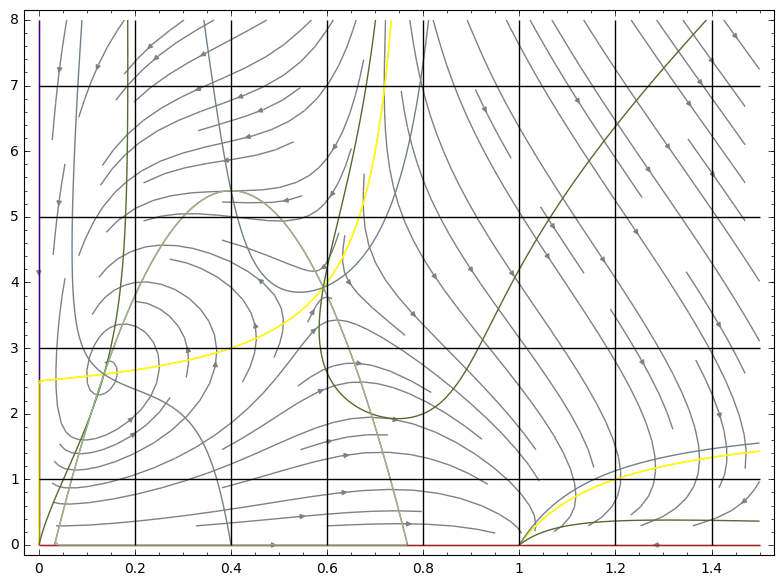

In [27]:
fs = f0s + f1s
p = []
p.append(streamline_plot(tuple(map(SR,vf)),
                         (x,0,1.5), (y,0,8), color="grey"))
# Plot polys
for col,l in zip(colors, fs):
    c = SR(l) == 0
    p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                           aspect_ratio='automatic',color=col))
# Plot grid
for s in range(1,8,2):
    c = SR(y) - SR(s) == 0
    p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                           aspect_ratio='automatic',color="black"))
for s in range(1,15,1):
    c = SR(x) - SR(s)/5 == 0
    p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                           aspect_ratio='automatic',color="black"))
show(sum(p))

In [28]:
len(fs)

8

In [29]:
3**len(fs)

6561

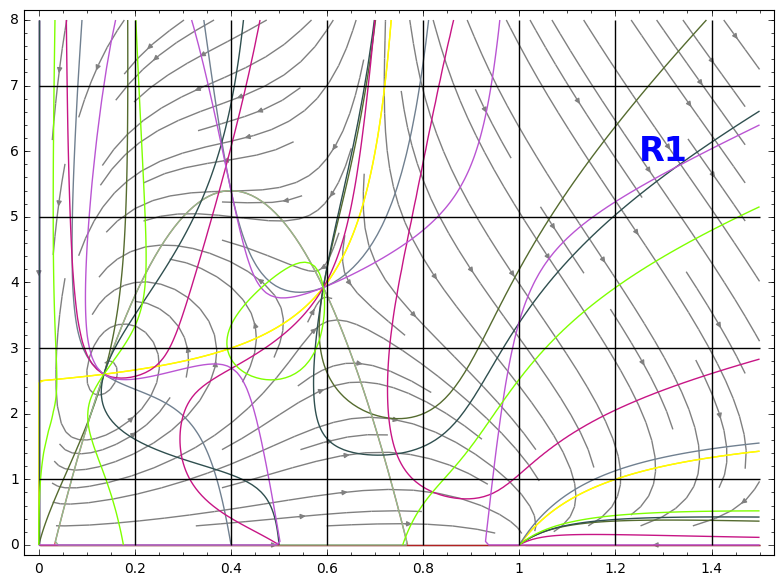

In [30]:
fs = f0s + f1s + f2s
p = []
p.append(streamline_plot(tuple(map(SR,vf)),
                         (x,0,1.5), (y,0,8), color="grey"))
# Plot polys
for col,l in zip(colors, fs):
    c = SR(l) == 0
    p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                           aspect_ratio='automatic',color=col))
# Plot grid
for s in range(1,8,2):
    c = SR(y) - SR(s) == 0
    p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                           aspect_ratio='automatic',color="black"))
for s in range(1,15,1):
    c = SR(x) - SR(s)/5 == 0
    p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                           aspect_ratio='automatic',color="black"))
p.append(text("R1", (1.3,6), fontsize="24",fontweight="bold"))
show(sum(p))

A rather large number of polynomials!

In [31]:
len(fs)

12

In [32]:
3**len(fs)

531441

However, we find only 3 intersect R1

In [33]:
R1 = [('GT', x - QQ(1.2)), ('LT', x - QQ(1.4)), ('LT', y - QQ(7)), ('GT', y - QQ(5))]; R1

[('GT', x - 6/5), ('LT', x - 7/5), ('LT', y - 7), ('GT', y - 5)]

In [34]:
R1fs = [f for f in fs if qcad(qf.exists([x,y], from_cnf([R1 + [('EQ', f)]]))) == 'TRUE']; R1fs

[-10*x^3*y + 3/2*x^2*y^2 + 10*x^2*y - 29/20*x*y^2 + 6*x^2 - 5/4*x*y + 1/5*y^2 - 6*x + 1/5*y,
 -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x,
 4*x^4*y - 6/5*x^3*y^2 - 4*x^3*y + 87/50*x^2*y^2 - 3/5*x^2*y - 78/125*x*y^2 + 1/200*y^3 + 4/5*x*y + 3/400*y^2 + 1/400*y]

Again, using mathematica

In [35]:
R1fs = [f for f in fs if mathematica_cad(existsmm([x,y], from_cnf([R1 + [('EQ', f)]])))]; R1fs

[-10*x^3*y + 3/2*x^2*y^2 + 10*x^2*y - 29/20*x*y^2 + 6*x^2 - 5/4*x*y + 1/5*y^2 - 6*x + 1/5*y,
 -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x,
 4*x^4*y - 6/5*x^3*y^2 - 4*x^3*y + 87/50*x^2*y^2 - 3/5*x^2*y - 78/125*x*y^2 + 1/200*y^3 + 4/5*x*y + 3/400*y^2 + 1/400*y]

### Zoom in inside R1

In [36]:
R1

[('GT', x - 6/5), ('LT', x - 7/5), ('LT', y - 7), ('GT', y - 5)]

In [37]:
p1, p2, p3 = R1fs

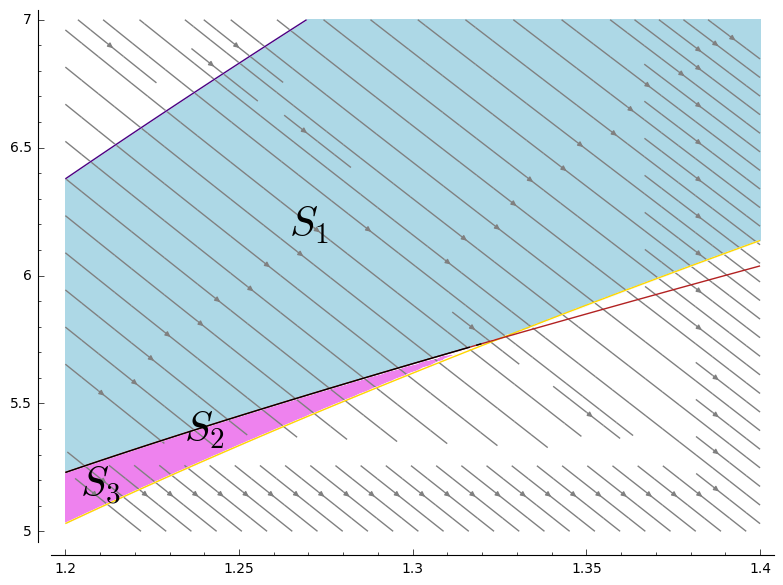

In [38]:
p = []
p.append(region_plot([SR(p1) < 0, SR(p2) > 0, SR(p3) < 0],
         (x,6/5,7/5), (y,5,7),
         incol="lightblue",
         aspect_ratio='automatic'))
p.append(region_plot([SR(p1) < 0, SR(p2) > 0, SR(p3) > 0],
         (x,6/5,7/5), (y,5,7),
         incol="violet",
         aspect_ratio='automatic'))
p.append(streamline_plot(tuple(map(SR,vf)),
                         (x,6/5,7/5), (y,5,7), color="grey"))
# Plot polys
for col,l in zip(colors, R1fs):
    c = SR(l) == 0
    p.append(implicit_plot(c, (x,6/5,7/5), (y,5,7),
                           aspect_ratio='automatic',color=col))
p.append(region_plot([SR(p1) < 0, SR(p2) > 0, SR(p3) == 0],
         (x,6/5,7/5), (y,5,7),
         bordercol="black",
         aspect_ratio='automatic'))
p.append(text("$S_1$", (1.27,6.2), fontsize=30, color="black"))
p.append(text("$S_2$", (1.24,5.4), fontsize=30, color="black"))
p.append(text("$S_3$", (1.21,5.18), fontsize=30, color="black"))
show(sum(p))

In [40]:
R1

[('GT', x - 6/5), ('LT', x - 7/5), ('LT', y - 7), ('GT', y - 5)]

In [41]:
S1 = [[('LT', p1), ('GT', p2), ('LT', p3)] + R1]
S2 = [[('LT', p1), ('GT', p2), ('EQ', p3)] + R1]
S3 = [[('LT', p1), ('GT', p2), ('GT', p3)] + R1]

In [42]:
from_cnf(S1)

[-10 x^3 y + 3/2 x^2 y^2 + 10 x^2 y - 29/20 x y^2 + 6 x^2 - 5/4 x y + 1/5 y^2 - 6 x + 1/5 y < 0 /\ -3/5 x^4 y + 9/50 x^3 y^2 + 6/25 x^3 y - 231/1000 x^2 y^2 + 18/25 x^3 + 573/1000 x^2 y + 87/1250 x y^2 - 27/25 x^2 - 69/250 x y + 9/25 x > 0 /\ 4 x^4 y - 6/5 x^3 y^2 - 4 x^3 y + 87/50 x^2 y^2 - 3/5 x^2 y - 78/125 x y^2 + 1/200 y^3 + 4/5 x y + 3/400 y^2 + 1/400 y < 0 /\ x - 6/5 > 0 /\ x - 7/5 < 0 /\ y - 7 < 0 /\ y - 5 > 0]

In [43]:
S1

[[('LT',
   -10*x^3*y + 3/2*x^2*y^2 + 10*x^2*y - 29/20*x*y^2 + 6*x^2 - 5/4*x*y + 1/5*y^2 - 6*x + 1/5*y),
  ('GT',
   -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x),
  ('LT',
   4*x^4*y - 6/5*x^3*y^2 - 4*x^3*y + 87/50*x^2*y^2 - 3/5*x^2*y - 78/125*x*y^2 + 1/200*y^3 + 4/5*x*y + 3/400*y^2 + 1/400*y),
  ('GT', x - 6/5),
  ('LT', x - 7/5),
  ('LT', y - 7),
  ('GT', y - 5)]]

In [44]:
S2

[[('LT',
   -10*x^3*y + 3/2*x^2*y^2 + 10*x^2*y - 29/20*x*y^2 + 6*x^2 - 5/4*x*y + 1/5*y^2 - 6*x + 1/5*y),
  ('GT',
   -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x),
  ('EQ',
   4*x^4*y - 6/5*x^3*y^2 - 4*x^3*y + 87/50*x^2*y^2 - 3/5*x^2*y - 78/125*x*y^2 + 1/200*y^3 + 4/5*x*y + 3/400*y^2 + 1/400*y),
  ('GT', x - 6/5),
  ('LT', x - 7/5),
  ('LT', y - 7),
  ('GT', y - 5)]]

In [45]:
S3

[[('LT',
   -10*x^3*y + 3/2*x^2*y^2 + 10*x^2*y - 29/20*x*y^2 + 6*x^2 - 5/4*x*y + 1/5*y^2 - 6*x + 1/5*y),
  ('GT',
   -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x),
  ('GT',
   4*x^4*y - 6/5*x^3*y^2 - 4*x^3*y + 87/50*x^2*y^2 - 3/5*x^2*y - 78/125*x*y^2 + 1/200*y^3 + 4/5*x*y + 3/400*y^2 + 1/400*y),
  ('GT', x - 6/5),
  ('LT', x - 7/5),
  ('LT', y - 7),
  ('GT', y - 5)]]

Is there a transition $S_1 \to S_2$?

In [46]:
not lzz_mathematica(vf, h=S1+S2, p=S1)

True

Mathematica says there is a transition!

Is there a transition $S_2 \to S_1$?

In [47]:
not lzz_mathematica(vf, h=S1+S2, p=S2)

False

Mathematica says no transition!

Is there a transition $S_2 \to S_3$?

In [48]:
not lzz_mathematica(vf, h=S2+S3, p=S2)

True

Yes!

Is there a transition $S_3 \to S_2$?

In [49]:
not lzz_mathematica(vf, h=S2+S3, p=S3)

False

No!

Is there a transition $S_1 \to S_3$?

In [50]:
not lzz_mathematica(vf, h=S1+S3, p=S1)

False

No -- we have to go through $S_2$ on the way!

## General grid intersections

How about a general grid square?

$1$ level lie intersections

In [51]:
fs = f0s + f1s
dy = QQ(2)
dx = QQ(1)/5
# Plot grid
points = []
for n in range(1,8,2):
    y1 = QQ(n)
    y0 = y1 - dy
    print " = start of outer loop"
#    print " - started implicit plotting..."
#    p.append(implicit_plot(SR(y) - SR(y1) == 0, (x,0,1.5), (y,0,8),
#                               aspect_ratio='automatic',color="black"))
#    print " - ended implicit plotting!"
    for m in range(1,8,1):
        print " = start of inner loop"
        x1 = QQ(m)/5
        x0 = x1 - dx
        R = [('GT', x - x0), ('LT', x - x1), ('GT', y - y0), ('LT', y - y1)]
        # QEPCAD Rfs = [f for f in fs if qcad(qf.exists([x,y], from_cnf([R + [('EQ', f)]]))) == 'TRUE']
        Rfs = [f for f in fs if mathematica_cad(existsmm([x,y], from_cnf([R + [('EQ', f)]])))]
        print "{}, {}: {}".format(x0, y0, str(Rfs))
        print " - adding label"
        points.append((len(Rfs), ((x1 + x0)/2,(y1 + y0)/2)))
        #p.append(text("{}{}".format('>= ' if fail else '', len(Rfs)), ((x1 + x0)/2,(y1 + y0)/2), fontsize="10",fontweight="bold"))
        print " = end of inner loop"
        #p.append(text("{}{}".format('>= ' if fail else '', len(Rfs)), ((x1 + x0)/2,(y1 + y0)/2), fontsize="10",fontweight="bold"))

 = start of outer loop
 = start of inner loop
0, -1: [y, 40*x^2 - 32*x + y + 1, -10*x^3*y + 3/2*x^2*y^2 + 10*x^2*y - 29/20*x*y^2 + 6*x^2 - 5/4*x*y + 1/5*y^2 - 6*x + 1/5*y, -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y, 24*x^3*y - 48*x^3 - 154/5*x^2*y + 336/5*x^2 + 232/25*x*y - 1/20*y^2 - 96/5*x - 1/20*y]
 - adding label
 = end of inner loop
 = start of inner loop
1/5, -1: [y, -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y, 24*x^3*y - 48*x^3 - 154/5*x^2*y + 336/5*x^2 + 232/25*x*y - 1/20*y^2 - 96/5*x - 1/20*y]
 - adding label
 = end of inner loop
 = start of inner loop
2/5, -1: [y, -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y, 24*x^3*y - 48*x^3 - 154/5*x^2*y + 336/5*x^2 + 232/25*x*y - 1/20*y^2 - 96/5*x - 1/20*y]
 - adding label
 = end of inner loop
 = start of inner loop
3/5, -1: [y, 40*x^2 - 32*x + y + 1, -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y]
 - adding label
 = end of inner loop
 = start of inner loop
4/5, -1: [5*x*y - 10*x - 4*y + 10, y, 3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x, -10*x^3*y + 3/2*x^2*y^2 + 

!!! plotting actual figure !!!
now plot labels
!!!plotting!!!


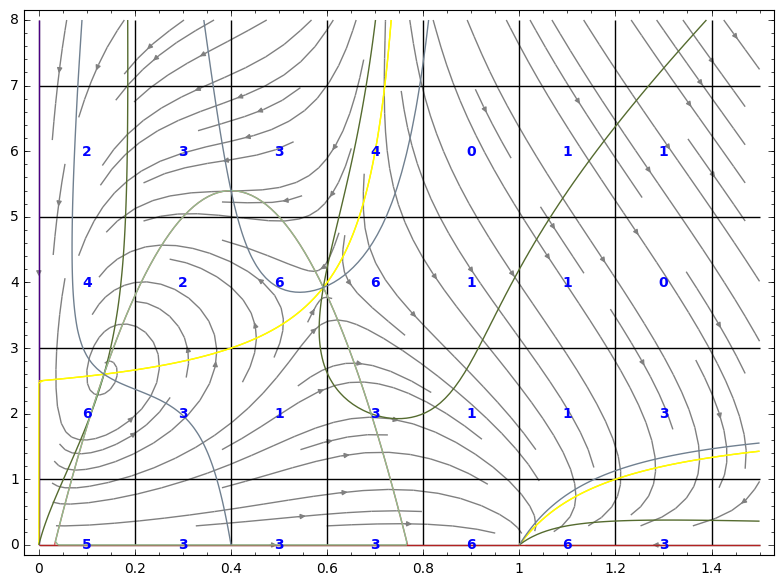

In [52]:
print "!!! plotting actual figure !!!"
p = []
p.append(streamline_plot(tuple(map(SR,vf)),
                         (x,0,1.5), (y,0,8), color="grey"))
for m in range(1,8,1):
    x0 = QQ(m)/5
    x1 = x0 + dx 
    p.append(implicit_plot(SR(x) - SR(x0) == 0, (x,0,1.5), (y,0,8),
                   aspect_ratio='automatic',color="black"))
for n in range(1,8,2):
    y1 = QQ(n)
    y0 = y1 - dy
    p.append(implicit_plot(SR(y) - SR(y1) == 0, (x,0,1.5), (y,0,8),
                               aspect_ratio='automatic',color="black"))
# Plot polys
for col,l in zip(colors, fs):
    c = SR(l) == 0
    p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                           aspect_ratio='automatic',color=col))
print "now plot labels"
for txt, pt in points:
    p.append(text(txt, pt, fontsize="10",fontweight="bold"))
print "!!!plotting!!!"
show(sum(p))

$2$ level lie intersections

In [134]:
fs = f0s + f1s + f2s
dy = QQ(2)
dx = QQ(1)/5
# Plot grid
points = []
for n in range(1,8,2):
    y1 = QQ(n)
    y0 = y1 - dy
    print " = start of outer loop"
#    print " - started implicit plotting..."
#    p.append(implicit_plot(SR(y) - SR(y1) == 0, (x,0,1.5), (y,0,8),
#                               aspect_ratio='automatic',color="black"))
#    print " - ended implicit plotting!"
    for m in range(1,8,1):
        print " = start of inner loop"
        x1 = QQ(m)/5
        x0 = x1 - dx
        R = [('GT', x - x0), ('LT', x - x1), ('GT', y - y0), ('LT', y - y1)]
        Rfs = [f for f in fs if mathematica_cad(existsmm([x,y], from_cnf([R + [('EQ', f)]])))]
        print "{}, {}: {}".format(x0, y0, str(Rfs))
        print " - adding label"
        points.append((len(Rfs), ((x1 + x0)/2,(y1 + y0)/2)))
        #p.append(text("{}{}".format('>= ' if fail else '', len(Rfs)), ((x1 + x0)/2,(y1 + y0)/2), fontsize="10",fontweight="bold"))
        print " = end of inner loop"
        #p.append(text("{}{}".format('>= ' if fail else '', len(Rfs)), ((x1 + x0)/2,(y1 + y0)/2), fontsize="10",fontweight="bold"))

 = start of outer loop
 = start of inner loop
0, -1: [y, 40*x^2 - 32*x + y + 1, -10*x^3*y + 3/2*x^2*y^2 + 10*x^2*y - 29/20*x*y^2 + 6*x^2 - 5/4*x*y + 1/5*y^2 - 6*x + 1/5*y, -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y, 24*x^3*y - 48*x^3 - 154/5*x^2*y + 336/5*x^2 + 232/25*x*y - 1/20*y^2 - 96/5*x - 1/20*y, 20*x^5*y - 15*x^4*y^2 + 9/10*x^3*y^3 - 18*x^4*y + 45/2*x^3*y^2 - 261/200*x^2*y^3 - 37/5*x^3*y - 1719/200*x^2*y^2 + 493/1000*x*y^3 - 36/5*x^3 + 517/100*x^2*y + 111/400*x*y^2 - 1/50*y^3 + 54/5*x^2 + 429/400*x*y - 3/100*y^2 - 18/5*x - 1/100*y, 4*x^4*y - 6/5*x^3*y^2 - 4*x^3*y + 87/50*x^2*y^2 - 3/5*x^2*y - 78/125*x*y^2 + 1/200*y^3 + 4/5*x*y + 3/400*y^2 + 1/400*y, -48*x^5*y + 108/5*x^4*y^2 + 68/5*x^4*y - 924/25*x^3*y^2 + 432/5*x^4 + 86*x^3*y + 4827/250*x^2*y^2 - 4176/25*x^3 - 8007/125*x^2*y - 1782/625*x*y^2 + 1/200*y^3 + 2304/25*x^2 + 1204/125*x*y + 3/400*y^2 - 288/25*x + 1/400*y]
 - adding label
 = end of inner loop
 = start of inner loop
1/5, -1: [y, -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y, 24*x^3

!!! plotting actual figure !!!
now plot labels
!!!plotting!!!


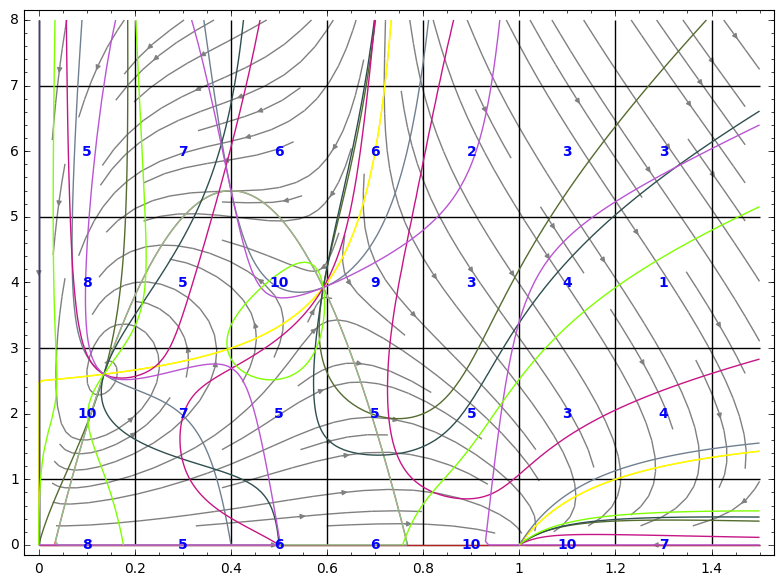

In [135]:
print "!!! plotting actual figure !!!"
p = []
p.append(streamline_plot(tuple(map(SR,vf)),
                         (x,0,1.5), (y,0,8), color="grey"))
for m in range(1,8,1):
    x0 = QQ(m)/5
    x1 = x0 + dx 
    p.append(implicit_plot(SR(x) - SR(x0) == 0, (x,0,1.5), (y,0,8),
                   aspect_ratio='automatic',color="black"))
for n in range(1,8,2):
    y1 = QQ(n)
    y0 = y1 - dy
    p.append(implicit_plot(SR(y) - SR(y1) == 0, (x,0,1.5), (y,0,8),
                               aspect_ratio='automatic',color="black"))
# Plot polys
for col,l in zip(colors, fs):
    c = SR(l) == 0
    p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                           aspect_ratio='automatic',color=col))
print "now plot labels"
for txt, pt in points:
    p.append(text(txt, pt, fontsize="10",fontweight="bold"))
print "!!!plotting!!!"
show(sum(p))

finer grid

In [136]:
fs = f0s + f1s + f2s
dy = QQ(1)
dx = QQ(1)/5
# Plot grid
points = []
for n in range(1,9,1):
    y1 = QQ(n)
    y0 = y1 - dy
    print " = start of outer loop"
#    print " - started implicit plotting..."
#    p.append(implicit_plot(SR(y) - SR(y1) == 0, (x,0,1.5), (y,0,8),
#                               aspect_ratio='automatic',color="black"))
#    print " - ended implicit plotting!"
    for m in range(1,8,1):
        print " = start of inner loop"
        x1 = QQ(m)/5
        x0 = x1 - dx
        R = [('GT', x - x0), ('LT', x - x1), ('GT', y - y0), ('LT', y - y1)]
        Rfs = [f for f in fs if mathematica_cad(existsmm([x,y], from_cnf([R + [('EQ', f)]])))]
        print "{}, {}: {}".format(x0, y0, str(Rfs))
        print " - adding label"
        points.append((len(Rfs), ((x1 + x0)/2,(y1 + y0)/2)))
        #p.append(text("{}{}".format('>= ' if fail else '', len(Rfs)), ((x1 + x0)/2,(y1 + y0)/2), fontsize="10",fontweight="bold"))
        print " = end of inner loop"
        #p.append(text("{}{}".format('>= ' if fail else '', len(Rfs)), ((x1 + x0)/2,(y1 + y0)/2), fontsize="10",fontweight="bold"))

 = start of outer loop
 = start of inner loop
0, 0: [40*x^2 - 32*x + y + 1, -10*x^3*y + 3/2*x^2*y^2 + 10*x^2*y - 29/20*x*y^2 + 6*x^2 - 5/4*x*y + 1/5*y^2 - 6*x + 1/5*y, -2*x^2*y + 8/5*x*y - 1/20*y^2 - 1/20*y, -48*x^5*y + 108/5*x^4*y^2 + 68/5*x^4*y - 924/25*x^3*y^2 + 432/5*x^4 + 86*x^3*y + 4827/250*x^2*y^2 - 4176/25*x^3 - 8007/125*x^2*y - 1782/625*x*y^2 + 1/200*y^3 + 2304/25*x^2 + 1204/125*x*y + 3/400*y^2 - 288/25*x + 1/400*y]
 - adding label
 = end of inner loop
 = start of inner loop
1/5, 0: [24*x^3*y - 48*x^3 - 154/5*x^2*y + 336/5*x^2 + 232/25*x*y - 1/20*y^2 - 96/5*x - 1/20*y, 20*x^5*y - 15*x^4*y^2 + 9/10*x^3*y^3 - 18*x^4*y + 45/2*x^3*y^2 - 261/200*x^2*y^3 - 37/5*x^3*y - 1719/200*x^2*y^2 + 493/1000*x*y^3 - 36/5*x^3 + 517/100*x^2*y + 111/400*x*y^2 - 1/50*y^3 + 54/5*x^2 + 429/400*x*y - 3/100*y^2 - 18/5*x - 1/100*y]
 - adding label
 = end of inner loop
 = start of inner loop
2/5, 0: [-3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 

!!! plotting actual figure !!!
now plot labels
!!!plotting!!!


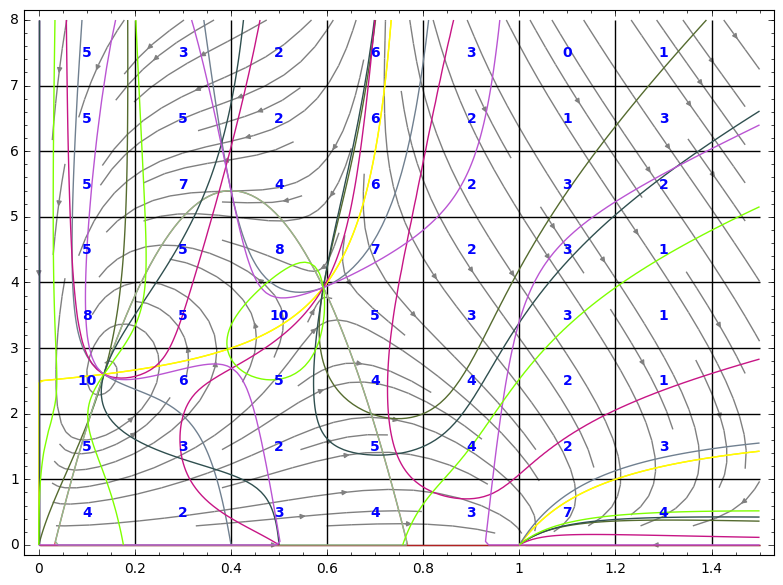

In [137]:
print "!!! plotting actual figure !!!"
p = []
p.append(streamline_plot(tuple(map(SR,vf)),
                         (x,0,1.5), (y,0,8), color="grey"))
for m in range(1,8,1):
    x0 = QQ(m)/5
    x1 = x0 + dx 
    p.append(implicit_plot(SR(x) - SR(x0) == 0, (x,0,1.5), (y,0,8),
                   aspect_ratio='automatic',color="black"))
for n in range(1,8,1):
    y1 = QQ(n)
    y0 = y1 - dy
    p.append(implicit_plot(SR(y) - SR(y1) == 0, (x,0,1.5), (y,0,8),
                               aspect_ratio='automatic',color="black"))
# Plot polys
for col,l in zip(colors, fs):
    c = SR(l) == 0
    p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                           aspect_ratio='automatic',color=col))
print "now plot labels"
for txt, pt in points:
    p.append(text(txt, pt, fontsize="10",fontweight="bold"))
print "!!!plotting!!!"
show(sum(p))

### Try with different $k$

In [53]:
PS.<x,y> = QQ[]
us = [x,y]
k=QQ(1)/5; b=QQ(0.6); c=QQ(0.3); e=QQ(0.05); f=QQ(2)
vf = vector([b*x*(QQ(1)-x) - c*x*(k-x)*y,
            -e*y*(QQ(1)+y)+f*x*(k-x)*y])
v0 = [2.0, 1.0]

In [54]:
factsx,factsy = [[a for a,_ in v.factor() if a.variables()] for v in vf]
factsx,factsy

([x, 5*x*y - 10*x - y + 10], [y, 40*x^2 - 8*x + y + 1])

In [55]:
f0s = factsx + factsy
f1s = [lie(vf, g) for g in f0s]
f2s = [lie(vf, g) for g in f1s]
f3s = [lie(vf, g) for g in f2s]

In [67]:
fs1 = f0s + f1s + f2s
fs1

[x,
 5*x*y - 10*x - y + 10,
 y,
 40*x^2 - 8*x + y + 1,
 3/10*x^2*y - 3/5*x^2 - 3/50*x*y + 3/5*x,
 -10*x^3*y + 3/2*x^2*y^2 - 2*x^2*y - 11/20*x*y^2 + 6*x^2 + 59/20*x*y + 1/20*y^2 - 6*x + 1/20*y,
 -2*x^2*y + 2/5*x*y - 1/20*y^2 - 1/20*y,
 24*x^3*y - 48*x^3 - 46/5*x^2*y + 264/5*x^2 + 22/25*x*y - 1/20*y^2 - 24/5*x - 1/20*y,
 -3/5*x^4*y + 9/50*x^3*y^2 - 12/25*x^3*y - 69/1000*x^2*y^2 + 18/25*x^3 + 609/1000*x^2*y + 33/5000*x*y^2 - 27/25*x^2 - 69/1000*x*y + 9/25*x,
 20*x^5*y - 15*x^4*y^2 + 9/10*x^3*y^3 + 18*x^4*y + 27/10*x^3*y^2 - 99/200*x^2*y^3 - 91/5*x^3*y + 513/200*x^2*y^2 + 11/125*x*y^3 - 36/5*x^3 - 551/100*x^2*y - 1119/2000*x*y^2 - 1/200*y^3 + 54/5*x^2 + 801/400*x*y - 3/400*y^2 - 18/5*x - 1/400*y,
 4*x^4*y - 6/5*x^3*y^2 + 4/5*x^3*y + 33/50*x^2*y^2 - 57/25*x^2*y - 21/250*x*y^2 + 1/200*y^3 + 1/5*x*y + 3/400*y^2 + 1/400*y,
 -48*x^5*y + 108/5*x^4*y^2 - 292/5*x^4*y - 276/25*x^3*y^2 + 432/5*x^4 + 2198/25*x^3*y + 507/250*x^2*y^2 - 3744/25*x^3 - 2304/125*x^2*y - 171/1250*x*y^2 + 1/200*y^3 + 1656/25*x^2 + 94/125*x*y + 3/400*y^2 - 72/25*x + 1/400*y]

In [88]:
fs = [fs1[1], fs1[2],fs1[5],fs1[7],fs1[8]]; fs

[5*x*y - 10*x - y + 10,
 y,
 -10*x^3*y + 3/2*x^2*y^2 - 2*x^2*y - 11/20*x*y^2 + 6*x^2 + 59/20*x*y + 1/20*y^2 - 6*x + 1/20*y,
 24*x^3*y - 48*x^3 - 46/5*x^2*y + 264/5*x^2 + 22/25*x*y - 1/20*y^2 - 24/5*x - 1/20*y,
 -3/5*x^4*y + 9/50*x^3*y^2 - 12/25*x^3*y - 69/1000*x^2*y^2 + 18/25*x^3 + 609/1000*x^2*y + 33/5000*x*y^2 - 27/25*x^2 - 69/1000*x*y + 9/25*x]

In [91]:
fs = f0s + f1s + f2s
dy = QQ(1)
dx = QQ(1)/5
# Plot grid
points = []
for n in range(1,9,1):
    y1 = QQ(n)
    y0 = y1 - dy
    print " = start of outer loop"
#    print " - started implicit plotting..."
#    p.append(implicit_plot(SR(y) - SR(y1) == 0, (x,0,1.5), (y,0,8),
#                               aspect_ratio='automatic',color="black"))
#    print " - ended implicit plotting!"
    for m in range(1,8,1):
        print " = start of inner loop"
        x1 = QQ(m)/5
        x0 = x1 - dx
        R = [('GT', x - x0), ('LT', x - x1), ('GT', y - y0), ('LT', y - y1)]
        Rfs = [f for f in fs if mathematica_cad(existsmm([x,y], from_cnf([R + [('EQ', f)]])))]
        print "{}, {}: {}".format(x0, y0, str(Rfs))
        print " - adding label"
        points.append((len(Rfs), ((x1 + x0)/2,(y1 + y0)/2)))
        #p.append(text("{}{}".format('>= ' if fail else '', len(Rfs)), ((x1 + x0)/2,(y1 + y0)/2), fontsize="10",fontweight="bold"))
        print " = end of inner loop"
        #p.append(text("{}{}".format('>= ' if fail else '', len(Rfs)), ((x1 + x0)/2,(y1 + y0)/2), fontsize="10",fontweight="bold"))

 = start of outer loop
 = start of inner loop
0, 0: [-10*x^3*y + 3/2*x^2*y^2 - 2*x^2*y - 11/20*x*y^2 + 6*x^2 + 59/20*x*y + 1/20*y^2 - 6*x + 1/20*y, 24*x^3*y - 48*x^3 - 46/5*x^2*y + 264/5*x^2 + 22/25*x*y - 1/20*y^2 - 24/5*x - 1/20*y, 4*x^4*y - 6/5*x^3*y^2 + 4/5*x^3*y + 33/50*x^2*y^2 - 57/25*x^2*y - 21/250*x*y^2 + 1/200*y^3 + 1/5*x*y + 3/400*y^2 + 1/400*y, -48*x^5*y + 108/5*x^4*y^2 - 292/5*x^4*y - 276/25*x^3*y^2 + 432/5*x^4 + 2198/25*x^3*y + 507/250*x^2*y^2 - 3744/25*x^3 - 2304/125*x^2*y - 171/1250*x*y^2 + 1/200*y^3 + 1656/25*x^2 + 94/125*x*y + 3/400*y^2 - 72/25*x + 1/400*y]
 - adding label
 = end of inner loop
 = start of inner loop
1/5, 0: []
 - adding label
 = end of inner loop
 = start of inner loop
2/5, 0: [-3/5*x^4*y + 9/50*x^3*y^2 - 12/25*x^3*y - 69/1000*x^2*y^2 + 18/25*x^3 + 609/1000*x^2*y + 33/5000*x*y^2 - 27/25*x^2 - 69/1000*x*y + 9/25*x, 20*x^5*y - 15*x^4*y^2 + 9/10*x^3*y^3 + 18*x^4*y + 27/10*x^3*y^2 - 99/200*x^2*y^3 - 91/5*x^3*y + 513/200*x^2*y^2 + 11/125*x*y^3 - 36/5*x^3 - 5

!!! plotting actual figure !!!
now plot labels
!!!plotting!!!


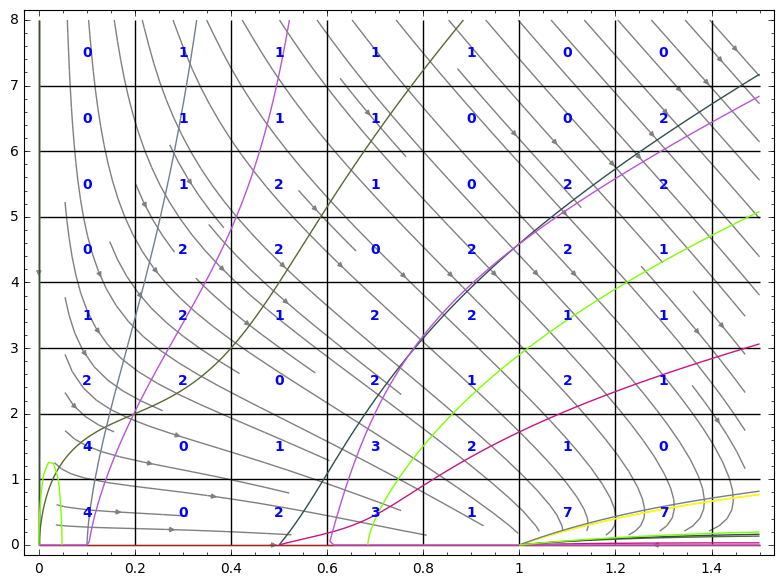

In [92]:
print "!!! plotting actual figure !!!"
p = []
p.append(streamline_plot(tuple(map(SR,vf)),
                         (x,0,1.5), (y,0,8), color="grey"))
for m in range(1,8,1):
    x0 = QQ(m)/5
    x1 = x0 + dx 
    p.append(implicit_plot(SR(x) - SR(x0) == 0, (x,0,1.5), (y,0,8),
                   aspect_ratio='automatic',color="black"))
for n in range(1,8,1):
    y1 = QQ(n)
    y0 = y1 - dy
    p.append(implicit_plot(SR(y) - SR(y1) == 0, (x,0,1.5), (y,0,8),
                               aspect_ratio='automatic',color="black"))
# Plot polys
for col,l in zip(colors, fs):
    c = SR(l) == 0
    p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                           aspect_ratio='automatic',color=col))
print "now plot labels"
for txt, pt in points:
    p.append(text(txt, pt, fontsize="10",fontweight="bold"))
print "!!!plotting!!!"
show(sum(p))

In [93]:
len(fs)

12

In [262]:
9^12

282429536481

In [94]:
7^len(fs) - 3^len(fs)

13840755760

In [110]:
7^1 - 3^1

4

In [263]:
7^2 - 3^2

40

In [99]:
8*8*4*(7^7 - 3^7)

210267136

In [106]:
8*8*4*(7^7 - 3^7)*(7^7 - 3^7)

172704173756416

In [104]:
8*8*4

256

In [118]:
8*8*((7^2 - 3^2) + 2*3^2*3^2 + 2*3^2 + 2*(7^2 - 3^2))

19200

In [116]:
8*8*((7^3 - 3^3) + 2*3^3*3^3 + 2*3^3 + 2*(7^3 - 3^3))

157440

### Parametric transitions

In [198]:
PS.<k,x,y> = QQ[]
us = [x,y]
b=QQ(0.6); c=QQ(0.3); e=QQ(0.05); f=QQ(2)
vf = vector([b*x*(QQ(1)-x) - c*x*(k-x)*y,
            -e*y*(QQ(1)+y)+f*x*(k-x)*y])
v0 = [2.0, 1.0]

In [199]:
factsx,factsy = [[a for a,_ in v.factor() if a.variables()] for v in vf]
factsx,factsy

([x, -k*y + x*y - 2*x + 2], [y, -40*k*x + 40*x^2 + y + 1])

In [200]:
f0s = factsx + factsy
f1s = [lie(vf, g) for g in f0s]
f2s = [lie(vf, g) for g in f1s]
f3s = [lie(vf, g) for g in f2s]

In [224]:
fs = [f1s[0], f2s[0]];fs

[-3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x,
 -3/5*k^2*x^2*y + 6/5*k*x^3*y - 3/5*x^4*y + 9/100*k^2*x*y^2 - 27/100*k*x^2*y^2 + 9/50*x^3*y^2 + 27/50*k*x^2*y - 18/25*x^3*y + 3/200*k*x*y^2 - 3/200*x^2*y^2 + 18/25*x^3 - 69/200*k*x*y + 21/40*x^2*y - 27/25*x^2 + 9/25*x]

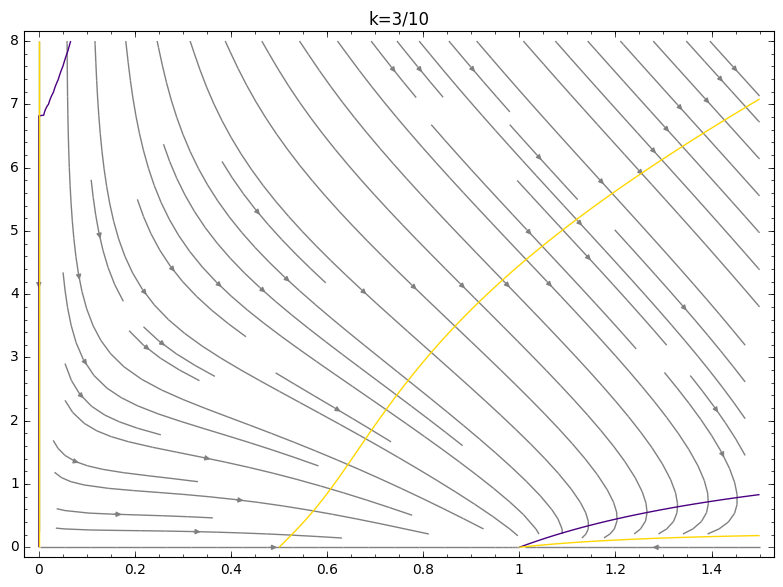

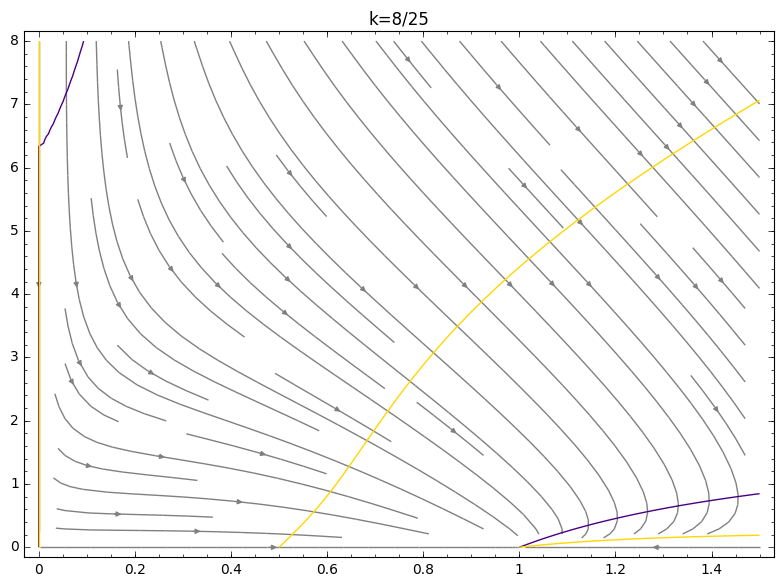

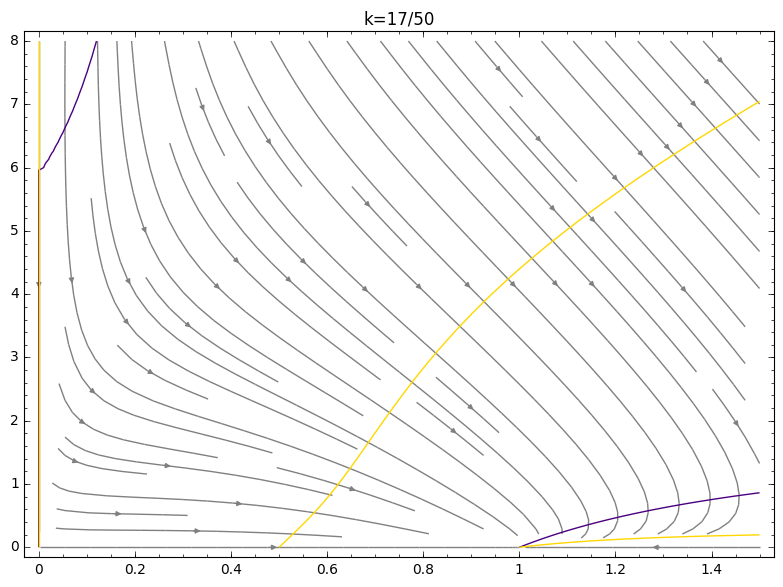

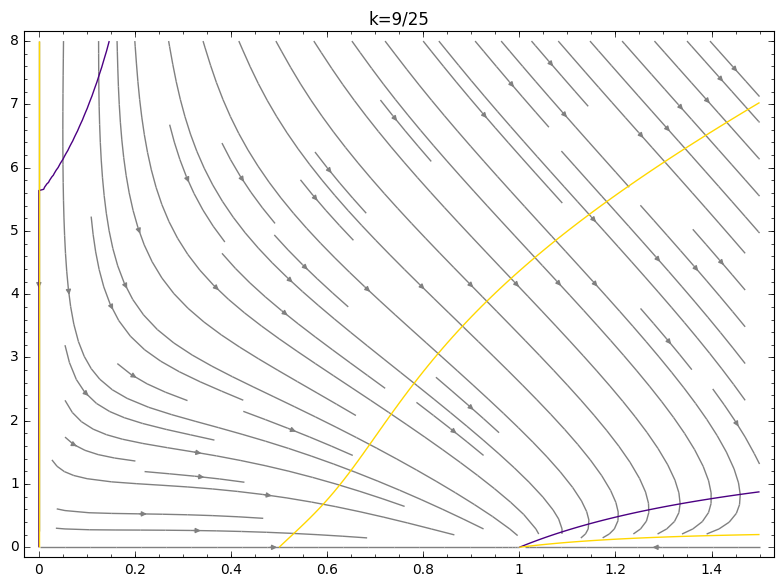

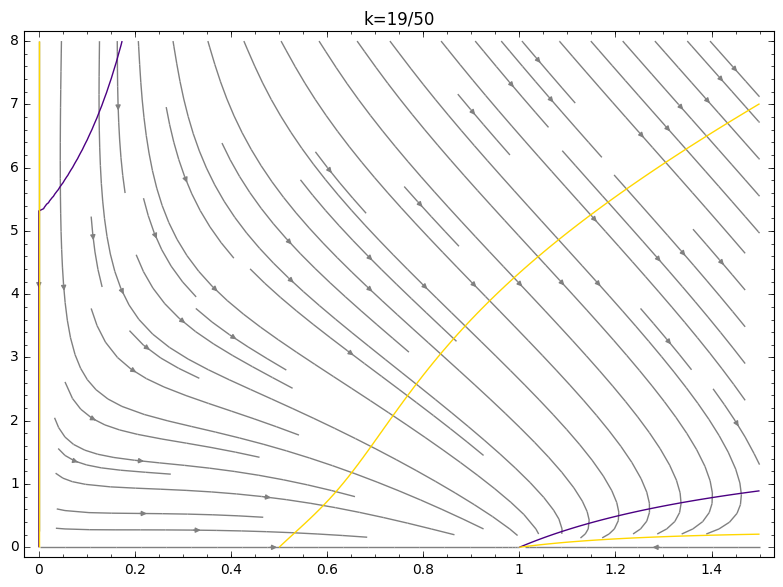

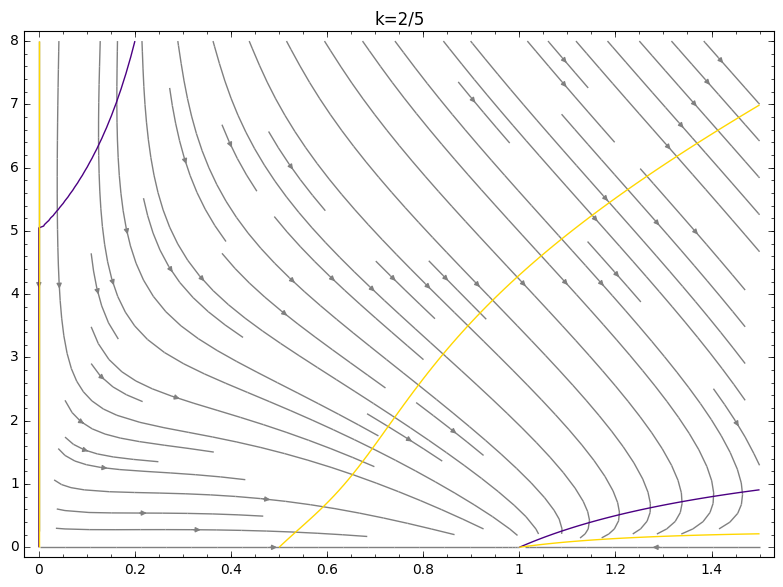

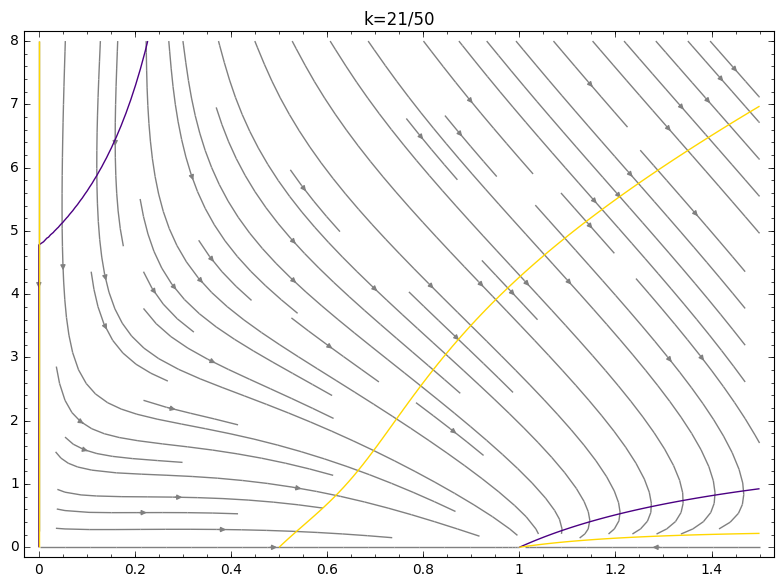

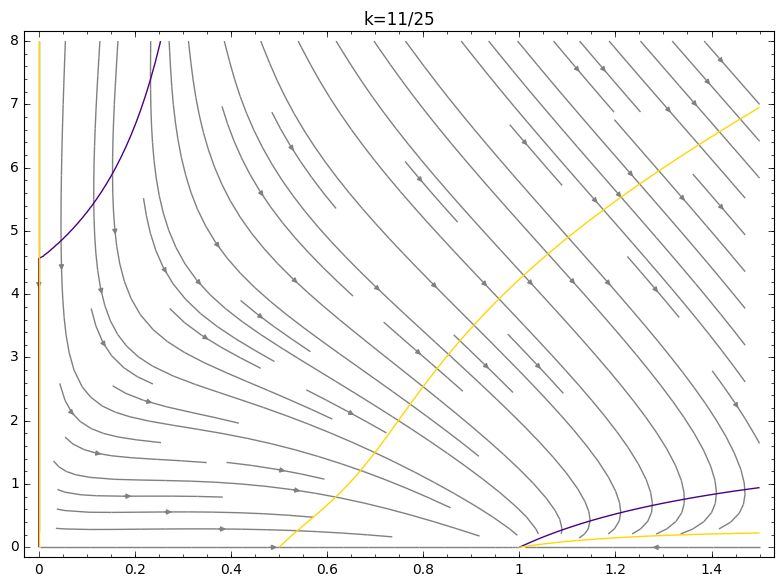

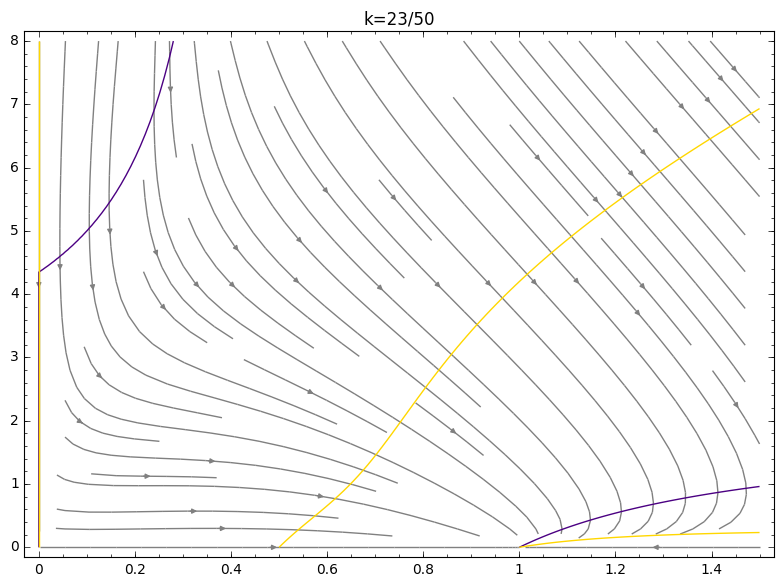

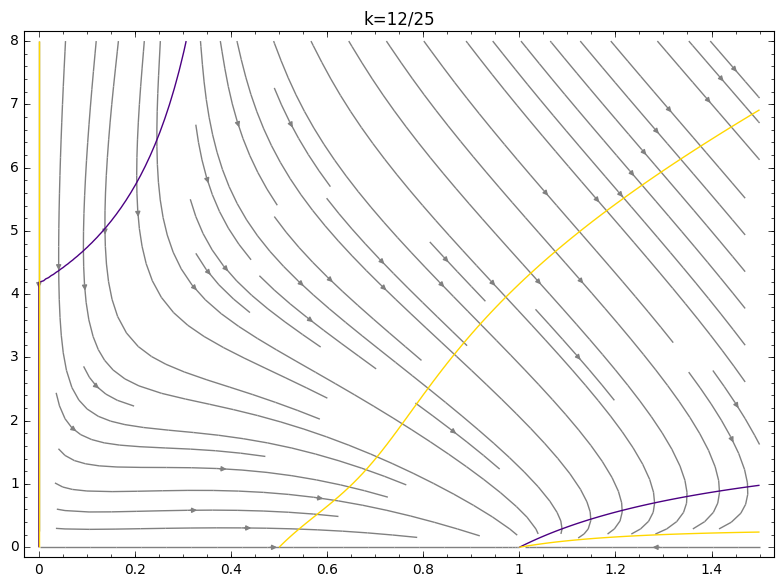

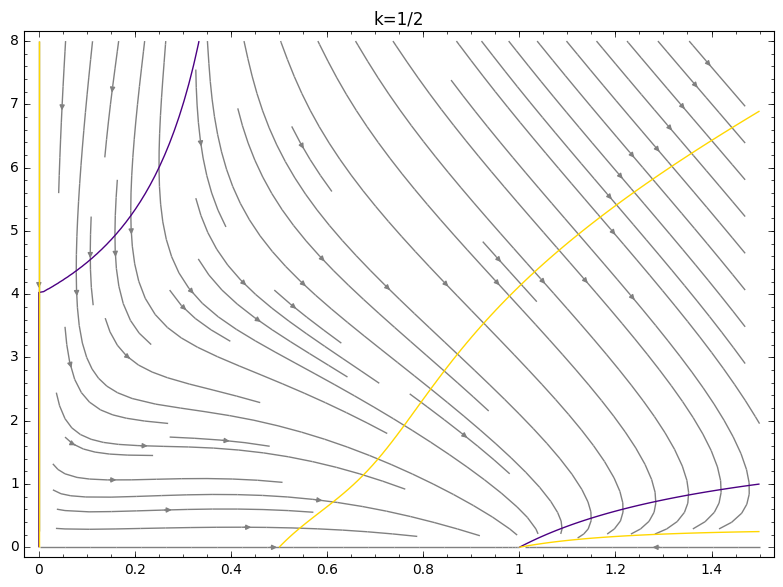

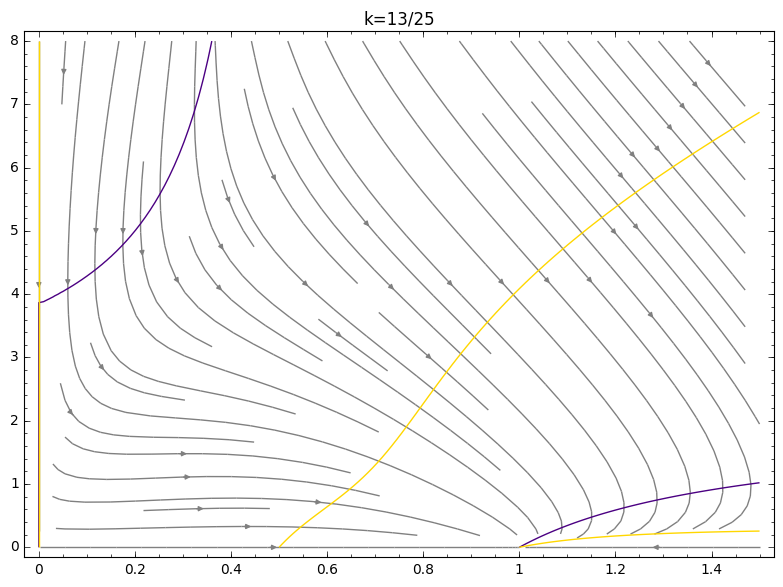

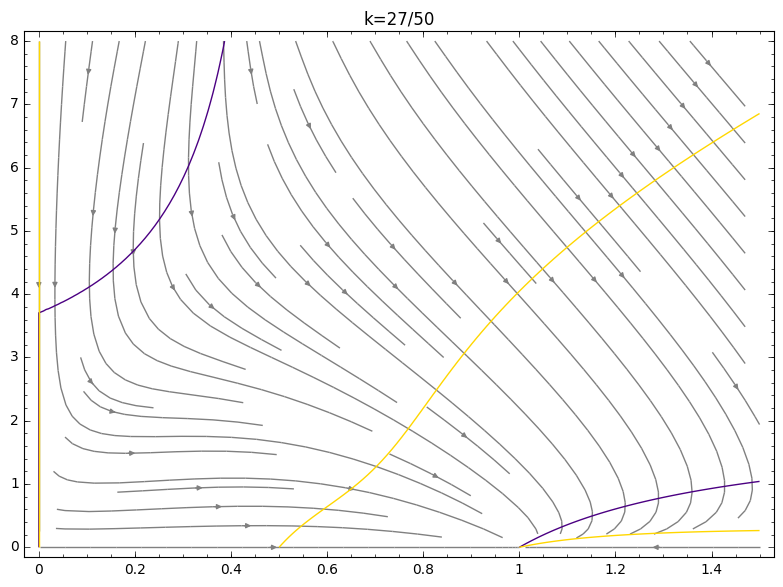

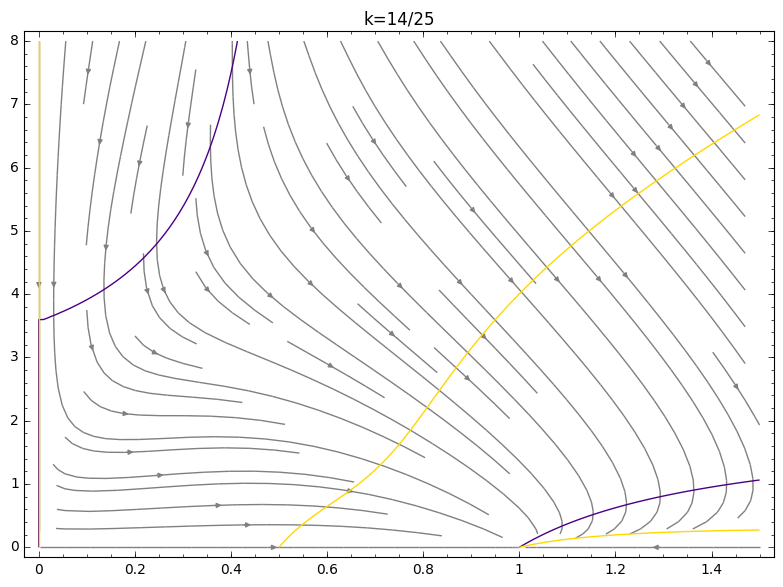

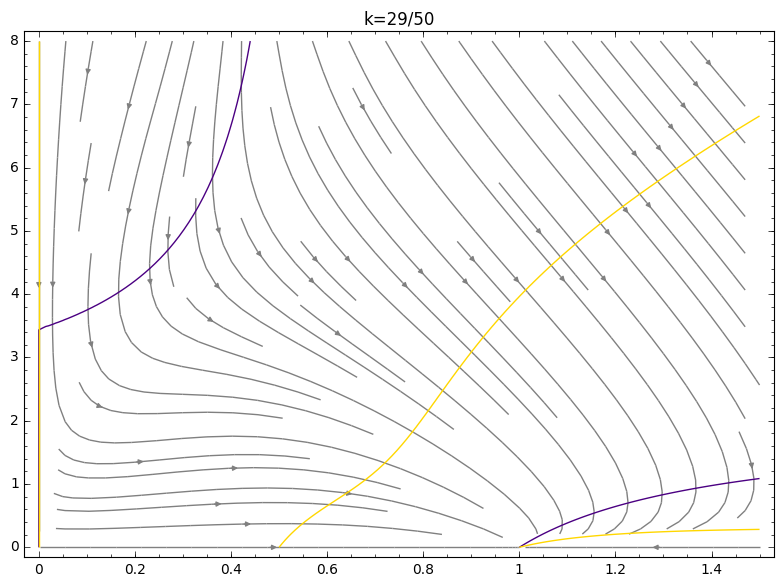

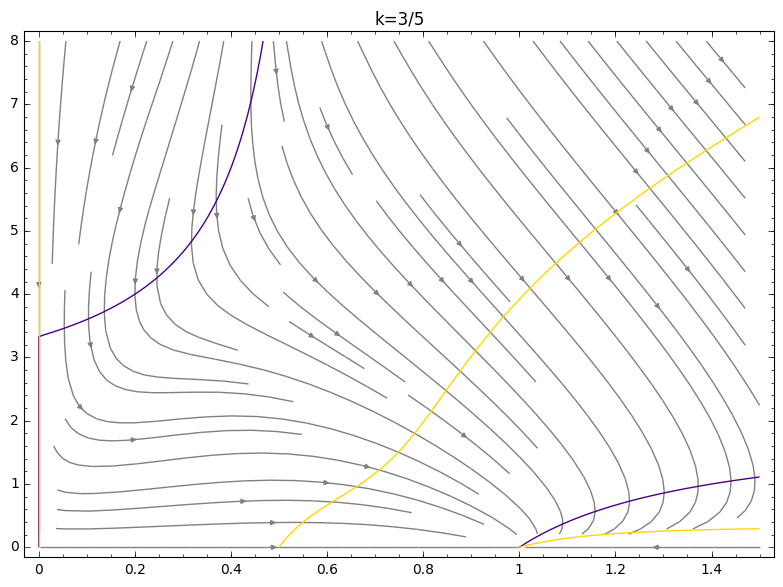

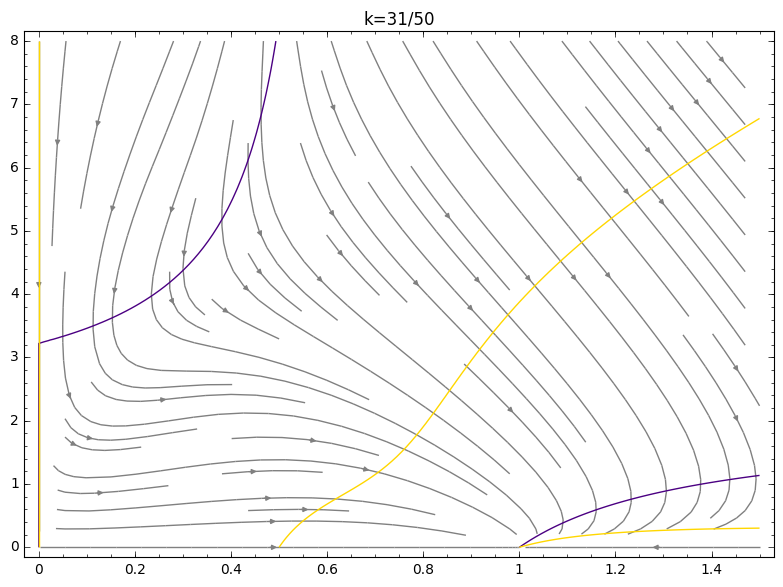

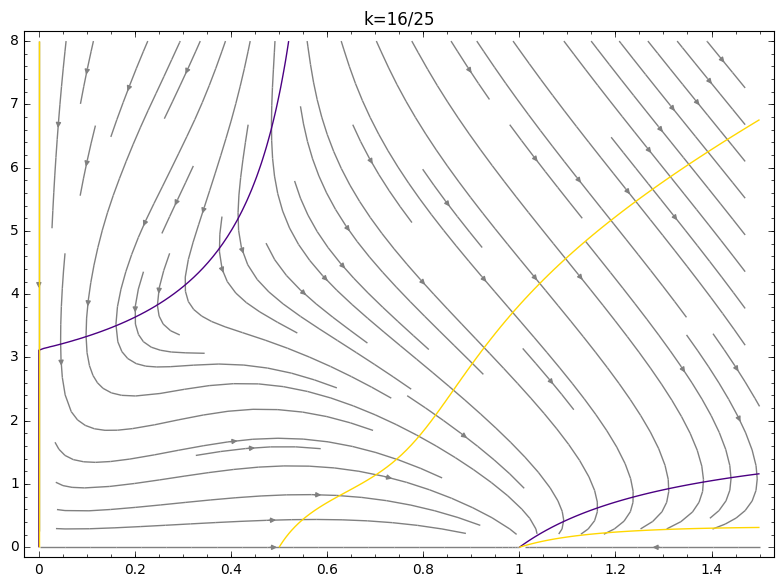

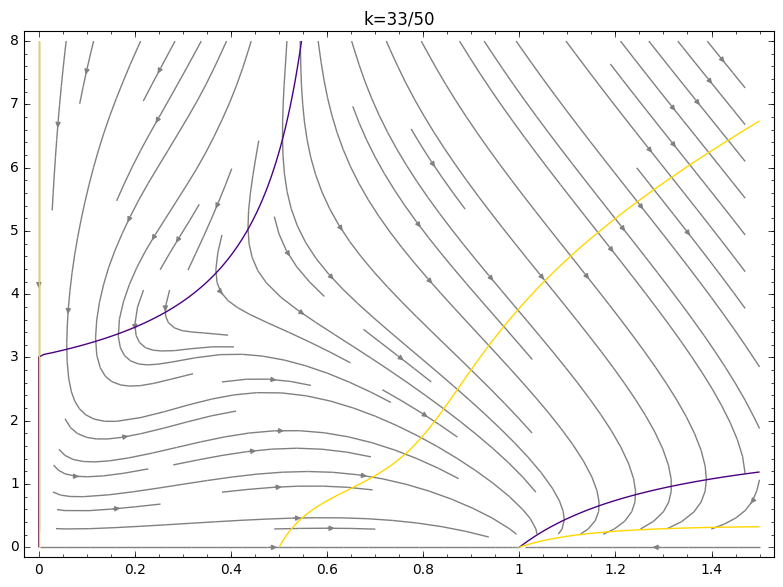

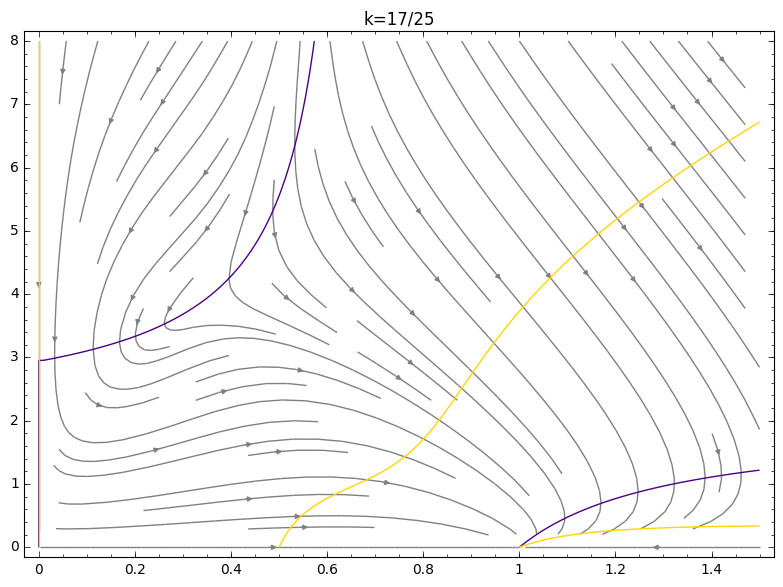

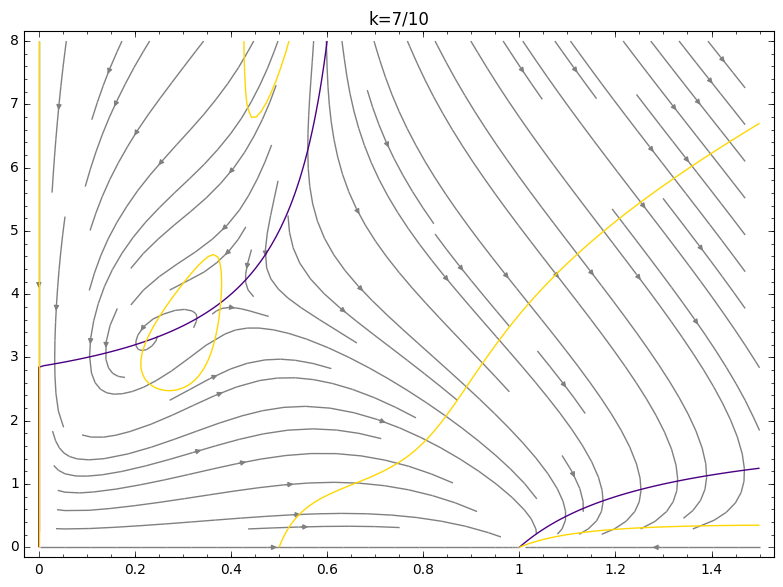

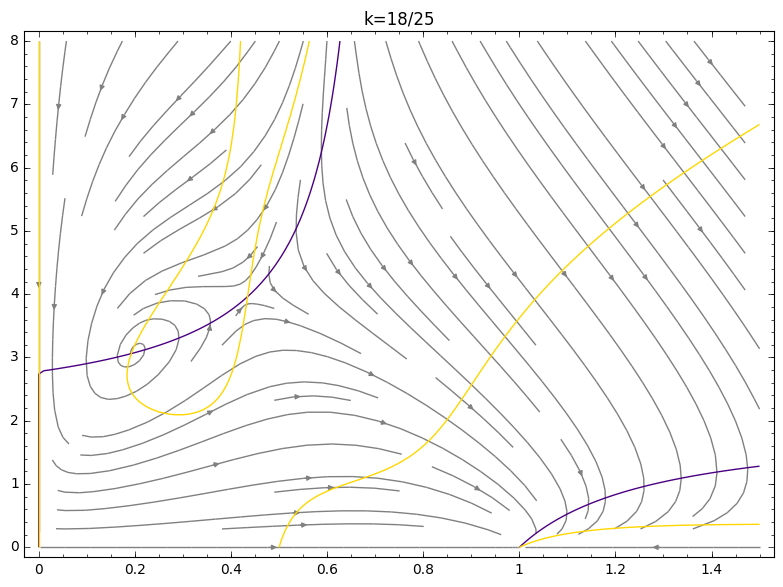

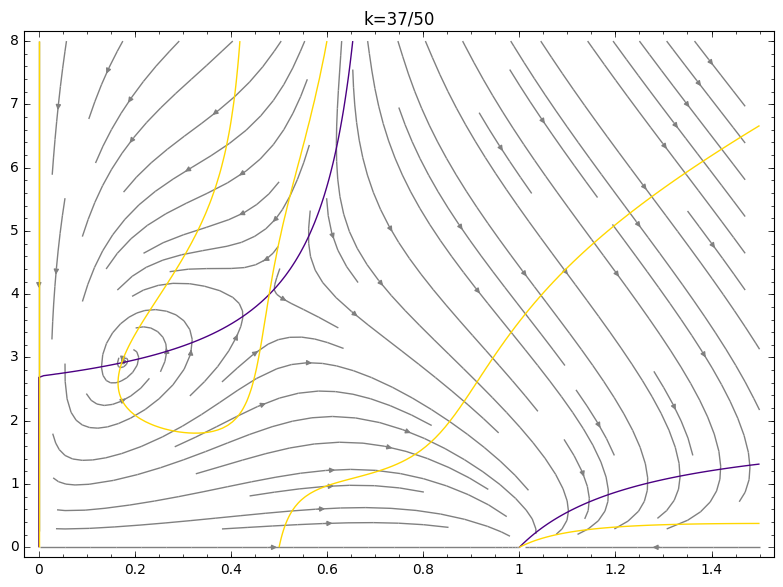

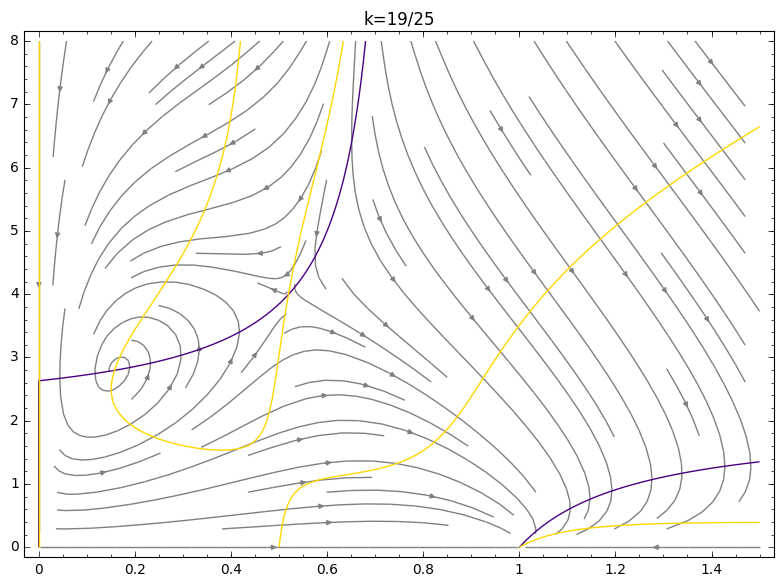

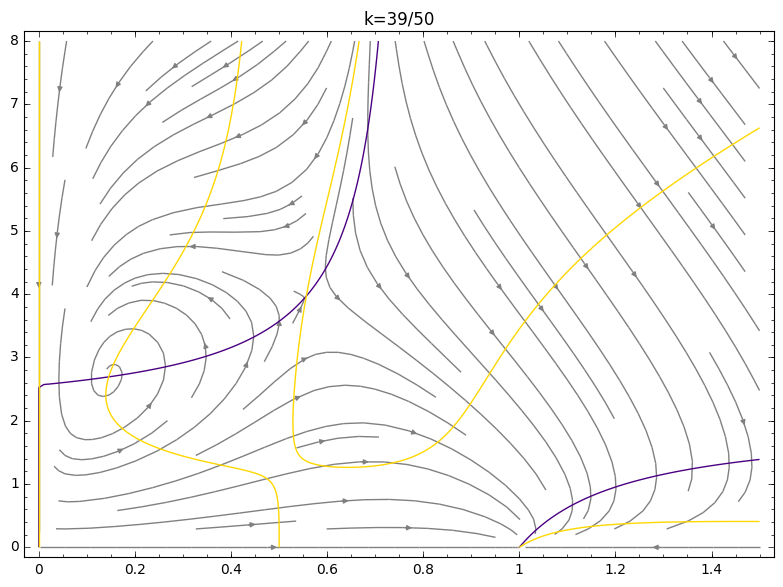

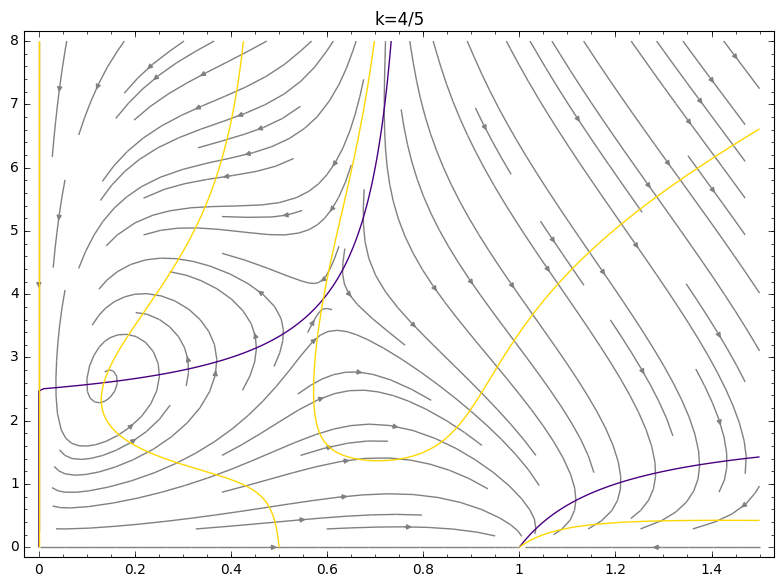

In [252]:
for n in range(0,26):
    k0 = QQ(0.3) + QQ(n)/QQ(50)
    p = []
    p.append(streamline_plot(tuple(map(SR,vf.subs(k=k0))),
                             (x,0,1.5), (y,0,8), color="grey",
                             title="k={}".format(k0)))
    for col,l in zip(colors, fs):
        c = SR(l.subs(k=k0)) == 0
        p.append(implicit_plot(c, (x,0,1.5), (y,0,8),
                               aspect_ratio='automatic',color=col))
    show(sum(p))

In [226]:
H = [('GEQ', x), ('GEQ', y)]

In [227]:
cp = ['LT', 'EQ', 'GT']

In [228]:
S = [[[(a, fs[0]), (b, fs[1])] + H] for a in cp for b in cp]; S

[[[('LT', -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x),
   ('LT',
    -3/5*k^2*x^2*y + 6/5*k*x^3*y - 3/5*x^4*y + 9/100*k^2*x*y^2 - 27/100*k*x^2*y^2 + 9/50*x^3*y^2 + 27/50*k*x^2*y - 18/25*x^3*y + 3/200*k*x*y^2 - 3/200*x^2*y^2 + 18/25*x^3 - 69/200*k*x*y + 21/40*x^2*y - 27/25*x^2 + 9/25*x),
   ('GEQ', x),
   ('GEQ', y)]],
 [[('LT', -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x),
   ('EQ',
    -3/5*k^2*x^2*y + 6/5*k*x^3*y - 3/5*x^4*y + 9/100*k^2*x*y^2 - 27/100*k*x^2*y^2 + 9/50*x^3*y^2 + 27/50*k*x^2*y - 18/25*x^3*y + 3/200*k*x*y^2 - 3/200*x^2*y^2 + 18/25*x^3 - 69/200*k*x*y + 21/40*x^2*y - 27/25*x^2 + 9/25*x),
   ('GEQ', x),
   ('GEQ', y)]],
 [[('LT', -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x),
   ('GT',
    -3/5*k^2*x^2*y + 6/5*k*x^3*y - 3/5*x^4*y + 9/100*k^2*x*y^2 - 27/100*k*x^2*y^2 + 9/50*x^3*y^2 + 27/50*k*x^2*y - 18/25*x^3*y + 3/200*k*x*y^2 - 3/200*x^2*y^2 + 18/25*x^3 - 69/200*k*x*y + 21/40*x^2*y - 27/25*x^2 + 9/25*x),
   ('GEQ', x),
   ('GEQ', y)]],
 [[('EQ', -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x),
   ('LT',
    -3/5*k^2*x^2*y + 6/5*k*x^3*y - 3/5*x^4*y + 9/100*k^2*x*y^2 - 27/100*k*x^2*y^2 + 9/50*x^3*y^2 + 27/50*k*x^2*y - 18/25*x^3*y + 3/200*k*x*y^2 - 3/200*x^2*y^2 + 18/25*x^3 - 69/200*k*x*y + 21/40*x^2*y - 27/25*x^2 + 9/25*x),
   ('GEQ', x),
   ('GEQ', y)]],
 [[('EQ', -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x),
   ('EQ',
    -3/5*k^2*x^2*y + 6/5*k*x^3*y - 3/5*x^4*y + 9/100*k^2*x*y^2 - 27/100*k*x^2*y^2 + 9/50*x^3*y^2 + 27/50*k*x^2*y - 18/25*x^3*y + 3/200*k*x*y^2 - 3/200*x^2*y^2 + 18/25*x^3 - 69/200*k*x*y + 21/40*x^2*y - 27/25*x^2 + 9/25*x),
   ('GEQ', x),
   ('GEQ', y)]],
 [[('EQ', -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x),
   ('GT',
    -3/5*k^2*x^2*y + 6/5*k*x^3*y - 3/5*x^4*y + 9/100*k^2*x*y^2 - 27/100*k*x^2*y^2 + 9/50*x^3*y^2 + 27/50*k*x^2*y - 18/25*x^3*y + 3/200*k*x*y^2 - 3/200*x^2*y^2 + 18/25*x^3 - 69/200*k*x*y + 21/40*x^2*y - 27/25*x^2 + 9/25*x),
   ('GEQ', x),
   ('GEQ', y)]],
 [[('GT', -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x),
   ('LT',
    -3/5*k^2*x^2*y + 6/5*k*x^3*y - 3/5*x^4*y + 9/100*k^2*x*y^2 - 27/100*k*x^2*y^2 + 9/50*x^3*y^2 + 27/50*k*x^2*y - 18/25*x^3*y + 3/200*k*x*y^2 - 3/200*x^2*y^2 + 18/25*x^3 - 69/200*k*x*y + 21/40*x^2*y - 27/25*x^2 + 9/25*x),
   ('GEQ', x),
   ('GEQ', y)]],
 [[('GT', -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x),
   ('EQ',
    -3/5*k^2*x^2*y + 6/5*k*x^3*y - 3/5*x^4*y + 9/100*k^2*x*y^2 - 27/100*k*x^2*y^2 + 9/50*x^3*y^2 + 27/50*k*x^2*y - 18/25*x^3*y + 3/200*k*x*y^2 - 3/200*x^2*y^2 + 18/25*x^3 - 69/200*k*x*y + 21/40*x^2*y - 27/25*x^2 + 9/25*x),
   ('GEQ', x),
   ('GEQ', y)]],
 [[('GT', -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x),
   ('GT',
    -3/5*k^2*x^2*y + 6/5*k*x^3*y - 3/5*x^4*y + 9/100*k^2*x*y^2 - 27/100*k*x^2*y^2 + 9/50*x^3*y^2 + 27/50*k*x^2*y - 18/25*x^3*y + 3/200*k*x*y^2 - 3/200*x^2*y^2 + 18/25*x^3 - 69/200*k*x*y + 21/40*x^2*y - 27/25*x^2 + 9/25*x),
   ('GEQ', x),
   ('GEQ', y)]]]

In [229]:
def fromcp(a, x, k0):
    if a == 'LT': return SR(x.subs(k=k0)) < 0
    elif a == 'EQ': return SR(x.subs(k=k0)) == 0
    elif a == 'GT': return SR(x.subs(k=k0)) > 0

In [231]:
RS = [[[(a, fs[0]), (b, fs[1])] + H] for a in cp for b in cp]; S

[[[('LT', -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x),
   ('LT',
    -3/5*k^2*x^2*y + 6/5*k*x^3*y - 3/5*x^4*y + 9/100*k^2*x*y^2 - 27/100*k*x^2*y^2 + 9/50*x^3*y^2 + 27/50*k*x^2*y - 18/25*x^3*y + 3/200*k*x*y^2 - 3/200*x^2*y^2 + 18/25*x^3 - 69/200*k*x*y + 21/40*x^2*y - 27/25*x^2 + 9/25*x),
   ('GEQ', x),
   ('GEQ', y)]],
 [[('LT', -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x),
   ('EQ',
    -3/5*k^2*x^2*y + 6/5*k*x^3*y - 3/5*x^4*y + 9/100*k^2*x*y^2 - 27/100*k*x^2*y^2 + 9/50*x^3*y^2 + 27/50*k*x^2*y - 18/25*x^3*y + 3/200*k*x*y^2 - 3/200*x^2*y^2 + 18/25*x^3 - 69/200*k*x*y + 21/40*x^2*y - 27/25*x^2 + 9/25*x),
   ('GEQ', x),
   ('GEQ', y)]],
 [[('LT', -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x),
   ('GT',
    -3/5*k^2*x^2*y + 6/5*k*x^3*y - 3/5*x^4*y + 9/100*k^2*x*y^2 - 27/100*k*x^2*y^2 + 9/50*x^3*y^2 + 27/50*k*x^2*y - 18/25*x^3*y + 3/200*k*x*y^2 - 3/200*x^2*y^2 + 18/25*x^3 - 69/200*k*x*y + 21/40*x^2*y - 27/25*x^2 + 9/25*x),
   ('GEQ', x),
   ('GEQ', y)]],
 [[('EQ', -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x),
   ('LT',
    -3/5*k^2*x^2*y + 6/5*k*x^3*y - 3/5*x^4*y + 9/100*k^2*x*y^2 - 27/100*k*x^2*y^2 + 9/50*x^3*y^2 + 27/50*k*x^2*y - 18/25*x^3*y + 3/200*k*x*y^2 - 3/200*x^2*y^2 + 18/25*x^3 - 69/200*k*x*y + 21/40*x^2*y - 27/25*x^2 + 9/25*x),
   ('GEQ', x),
   ('GEQ', y)]],
 [[('EQ', -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x),
   ('EQ',
    -3/5*k^2*x^2*y + 6/5*k*x^3*y - 3/5*x^4*y + 9/100*k^2*x*y^2 - 27/100*k*x^2*y^2 + 9/50*x^3*y^2 + 27/50*k*x^2*y - 18/25*x^3*y + 3/200*k*x*y^2 - 3/200*x^2*y^2 + 18/25*x^3 - 69/200*k*x*y + 21/40*x^2*y - 27/25*x^2 + 9/25*x),
   ('GEQ', x),
   ('GEQ', y)]],
 [[('EQ', -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x),
   ('GT',
    -3/5*k^2*x^2*y + 6/5*k*x^3*y - 3/5*x^4*y + 9/100*k^2*x*y^2 - 27/100*k*x^2*y^2 + 9/50*x^3*y^2 + 27/50*k*x^2*y - 18/25*x^3*y + 3/200*k*x*y^2 - 3/200*x^2*y^2 + 18/25*x^3 - 69/200*k*x*y + 21/40*x^2*y - 27/25*x^2 + 9/25*x),
   ('GEQ', x),
   ('GEQ', y)]],
 [[('GT', -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x),
   ('LT',
    -3/5*k^2*x^2*y + 6/5*k*x^3*y - 3/5*x^4*y + 9/100*k^2*x*y^2 - 27/100*k*x^2*y^2 + 9/50*x^3*y^2 + 27/50*k*x^2*y - 18/25*x^3*y + 3/200*k*x*y^2 - 3/200*x^2*y^2 + 18/25*x^3 - 69/200*k*x*y + 21/40*x^2*y - 27/25*x^2 + 9/25*x),
   ('GEQ', x),
   ('GEQ', y)]],
 [[('GT', -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x),
   ('EQ',
    -3/5*k^2*x^2*y + 6/5*k*x^3*y - 3/5*x^4*y + 9/100*k^2*x*y^2 - 27/100*k*x^2*y^2 + 9/50*x^3*y^2 + 27/50*k*x^2*y - 18/25*x^3*y + 3/200*k*x*y^2 - 3/200*x^2*y^2 + 18/25*x^3 - 69/200*k*x*y + 21/40*x^2*y - 27/25*x^2 + 9/25*x),
   ('GEQ', x),
   ('GEQ', y)]],
 [[('GT', -3/10*k*x*y + 3/10*x^2*y - 3/5*x^2 + 3/5*x),
   ('GT',
    -3/5*k^2*x^2*y + 6/5*k*x^3*y - 3/5*x^4*y + 9/100*k^2*x*y^2 - 27/100*k*x^2*y^2 + 9/50*x^3*y^2 + 27/50*k*x^2*y - 18/25*x^3*y + 3/200*k*x*y^2 - 3/200*x^2*y^2 + 18/25*x^3 - 69/200*k*x*y + 21/40*x^2*y - 27/25*x^2 + 9/25*x),
   ('GEQ', x),
   ('GEQ', y)]]]

In [232]:
RS = [((a,b), [fromcp(a, fs[0], 3/5), fromcp(b, fs[1], 3/5)]) for a in cp for b in cp]; RS

[(('LT', 'LT'),
  [3/10*x^2*y - 3/5*x^2 - 9/50*x*y + 3/5*x < 0,
   -3/5*x^4*y + 9/50*x^3*y^2 - 177/1000*x^2*y^2 + 18/25*x^3 + 633/1000*x^2*y + 207/5000*x*y^2 - 27/25*x^2 - 207/1000*x*y + 9/25*x < 0]),
 (('LT', 'EQ'),
  [3/10*x^2*y - 3/5*x^2 - 9/50*x*y + 3/5*x < 0,
   -3/5*x^4*y + 9/50*x^3*y^2 - 177/1000*x^2*y^2 + 18/25*x^3 + 633/1000*x^2*y + 207/5000*x*y^2 - 27/25*x^2 - 207/1000*x*y + 9/25*x == 0]),
 (('LT', 'GT'),
  [3/10*x^2*y - 3/5*x^2 - 9/50*x*y + 3/5*x < 0,
   -3/5*x^4*y + 9/50*x^3*y^2 - 177/1000*x^2*y^2 + 18/25*x^3 + 633/1000*x^2*y + 207/5000*x*y^2 - 27/25*x^2 - 207/1000*x*y + 9/25*x > 0]),
 (('EQ', 'LT'),
  [3/10*x^2*y - 3/5*x^2 - 9/50*x*y + 3/5*x == 0,
   -3/5*x^4*y + 9/50*x^3*y^2 - 177/1000*x^2*y^2 + 18/25*x^3 + 633/1000*x^2*y + 207/5000*x*y^2 - 27/25*x^2 - 207/1000*x*y + 9/25*x < 0]),
 (('EQ', 'EQ'),
  [3/10*x^2*y - 3/5*x^2 - 9/50*x*y + 3/5*x == 0,
   -3/5*x^4*y + 9/50*x^3*y^2 - 177/1000*x^2*y^2 + 18/25*x^3 + 633/1000*x^2*y + 207/5000*x*y^2 - 27/25*x^2 - 207/1000*x*y + 9/25*x == 0]),
 (('EQ', 'GT'),
  [3/10*x^2*y - 3/5*x^2 - 9/50*x*y + 3/5*x == 0,
   -3/5*x^4*y + 9/50*x^3*y^2 - 177/1000*x^2*y^2 + 18/25*x^3 + 633/1000*x^2*y + 207/5000*x*y^2 - 27/25*x^2 - 207/1000*x*y + 9/25*x > 0]),
 (('GT', 'LT'),
  [3/10*x^2*y - 3/5*x^2 - 9/50*x*y + 3/5*x > 0,
   -3/5*x^4*y + 9/50*x^3*y^2 - 177/1000*x^2*y^2 + 18/25*x^3 + 633/1000*x^2*y + 207/5000*x*y^2 - 27/25*x^2 - 207/1000*x*y + 9/25*x < 0]),
 (('GT', 'EQ'),
  [3/10*x^2*y - 3/5*x^2 - 9/50*x*y + 3/5*x > 0,
   -3/5*x^4*y + 9/50*x^3*y^2 - 177/1000*x^2*y^2 + 18/25*x^3 + 633/1000*x^2*y + 207/5000*x*y^2 - 27/25*x^2 - 207/1000*x*y + 9/25*x == 0]),
 (('GT', 'GT'),
  [3/10*x^2*y - 3/5*x^2 - 9/50*x*y + 3/5*x > 0,
   -3/5*x^4*y + 9/50*x^3*y^2 - 177/1000*x^2*y^2 + 18/25*x^3 + 633/1000*x^2*y + 207/5000*x*y^2 - 27/25*x^2 - 207/1000*x*y + 9/25*x > 0])]

In [233]:
S1 = [[('LT', fs[0])] + H]
S2 = [[('EQ', fs[0])] + H]
S3 = [[('GT', fs[0])] + H]

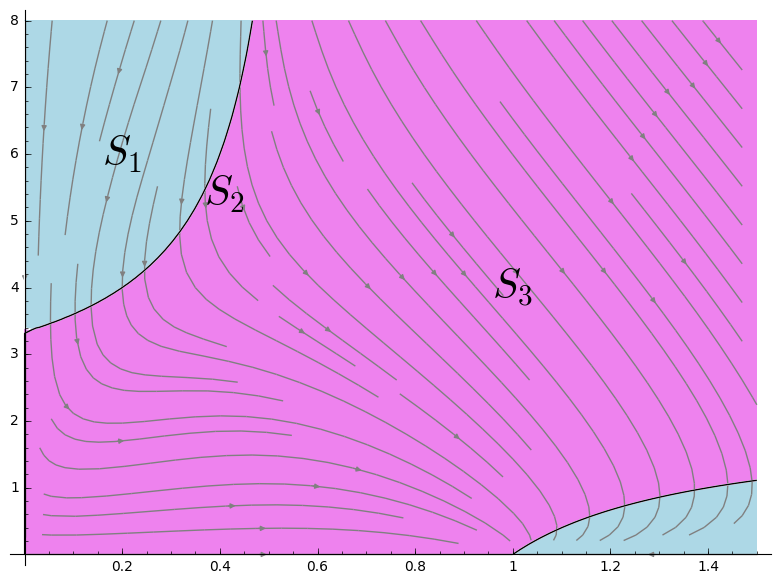

In [234]:
p = []
p.append(region_plot([SR(fs[0].subs(k=3/5)) < 0],
         (x,0,1.5), (y,0,8),
         incol="lightblue",
         aspect_ratio='automatic'))
p.append(region_plot([SR(fs[0].subs(k=3/5)) > 0],
         (x,0,1.5), (y,0,8),
         incol="violet",
         aspect_ratio='automatic'))
p.append(streamline_plot(tuple(map(SR,vf.subs(k=3/5))),
                         (x,0,1.5), (y,0,8), color="grey"))
p.append(region_plot([SR(fs[0].subs(k=3/5)) == 0],
         (x,0,1.5), (y,0,8),
         bordercol="black",
         aspect_ratio='automatic'))
p.append(text("$S_1$", (0.2,6), fontsize=30, color="black"))
p.append(text("$S_2$", (0.41,5.4), fontsize=30, color="black"))
p.append(text("$S_3$", (1,4), fontsize=30, color="black"))
sum(p)

R[0] LT LT indigo
R[2] LT GT firebrick
R[6] GT LT darkseagreen
R[8] GT GT darkslategrey
R[1] LT EQ gold
R[3] EQ LT indianred
R[4] EQ EQ yellow
R[5] EQ GT darkolivegreen
R[7] GT EQ slategrey


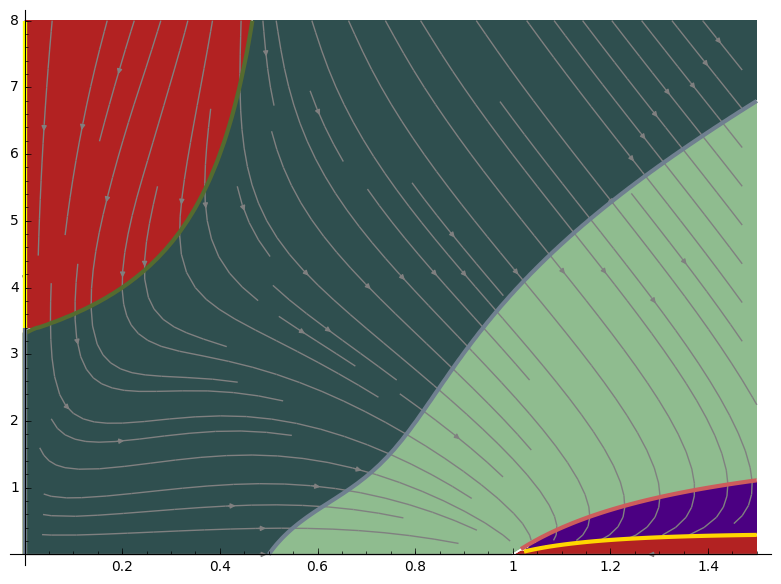

In [236]:
p = []
for i,(col,((a,b),R)) in enumerate(zip(colors,RS)):
    if a != 'EQ' and b != 'EQ':
        print "R[{}] {} {} {}".format(i, a, b, col)
        p.append(region_plot(R,
             (x,0,1.5), (y,0,8),
             incol=col,
             bordercol=None,
             aspect_ratio='automatic', legend_label='{} {}'.format(a,b)))
p.append(streamline_plot(tuple(map(SR,vf.subs(k=3/5))),
                         (x,0,1.5), (y,0,8), color="grey"))
for i,(col,((a,b),R)) in enumerate(zip(colors,RS)):
    if a == 'EQ' or b == 'EQ':
        print "R[{}] {} {} {}".format(i, a, b, col)
        p.append(region_plot(R,
             (x,0,1.5), (y,0,8),
             incol=col,
             bordercol=col,
             borderwidth=3,
             aspect_ratio='automatic', legend_label='{} {}'.format(a,b)))
show(sum(p))

In [253]:
R4S = [((a,b), [fromcp(a, fs[0], 4/5), fromcp(b, fs[1], 4/5)]) for a in cp for b in cp]; R4S

[(('LT', 'LT'),
  [3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x < 0,
   -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x < 0]),
 (('LT', 'EQ'),
  [3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x < 0,
   -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x == 0]),
 (('LT', 'GT'),
  [3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x < 0,
   -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x > 0]),
 (('EQ', 'LT'),
  [3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x == 0,
   -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x < 0]),
 (('EQ', 'EQ'),
  [3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x == 0,
   -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x == 0]),
 (('EQ', 'GT'),
  [3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x == 0,
   -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x > 0]),
 (('GT', 'LT'),
  [3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x > 0,
   -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x < 0]),
 (('GT', 'EQ'),
  [3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x > 0,
   -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x == 0]),
 (('GT', 'GT'),
  [3/10*x^2*y - 3/5*x^2 - 6/25*x*y + 3/5*x > 0,
   -3/5*x^4*y + 9/50*x^3*y^2 + 6/25*x^3*y - 231/1000*x^2*y^2 + 18/25*x^3 + 573/1000*x^2*y + 87/1250*x*y^2 - 27/25*x^2 - 69/250*x*y + 9/25*x > 0])]

R[0] LT LT indigo
R[2] LT GT firebrick
R[6] GT LT darkseagreen
R[8] GT GT darkslategrey
R[1] LT EQ gold
R[3] EQ LT indianred
R[4] EQ EQ yellow
R[5] EQ GT darkolivegreen
R[7] GT EQ slategrey


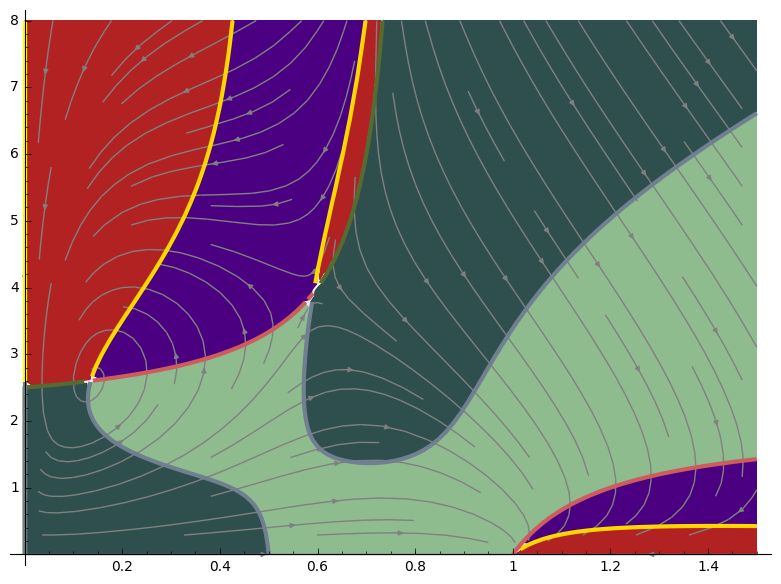

In [254]:
p = []
for i,(col,((a,b),R)) in enumerate(zip(colors,R4S)):
    if a != 'EQ' and b != 'EQ':
        print "R[{}] {} {} {}".format(i, a, b, col)
        p.append(region_plot(R,
             (x,0,1.5), (y,0,8),
             incol=col,
             bordercol=None,
             aspect_ratio='automatic', legend_label='{} {}'.format(a,b)))
p.append(streamline_plot(tuple(map(SR,vf.subs(k=4/5))),
                         (x,0,1.5), (y,0,8), color="grey"))
for i,(col,((a,b),R)) in enumerate(zip(colors,R4S)):
    if a == 'EQ' or b == 'EQ':
        print "R[{}] {} {} {}".format(i, a, b, col)
        p.append(region_plot(R,
             (x,0,1.5), (y,0,8),
             incol=col,
             bordercol=col,
             borderwidth=3,
             aspect_ratio='automatic', legend_label='{} {}'.format(a,b)))
show(sum(p))

In [237]:
not lzz_mathematica(vf, h=S[2]+S[5], p=S[2], assume=[[('EQ', k - QQ(3)/5)]])

True

In [238]:
not lzz_mathematica(vf, h=S[2]+S[5], p=S[5], assume=[[('EQ', k - QQ(3)/5)]])

False

In [239]:
not lzz_mathematica(vf, h=S[5]+S[8], p=S[5], assume=[[('EQ', k - QQ(3)/5)]])

True

In [240]:
not lzz_mathematica(vf, h=S[5]+S[8], p=S[8], assume=[[('EQ', k - QQ(3)/5)]])

False

Parametric transitions $\frac 3 {10} \leq k \leq \frac 4 5$

In [ ]:
assume = [[('GEQ', k - QQ(3)/x10), ('LEQ', k - QQ(4)/5)]]; assume

In [256]:
from_cnf(assume)

[k - 3/10 >= 0 /\ k - 4/5 <= 0]

In [257]:
lzz_mathematica(vf, h=S[2]+S[5], p=S[2], assume=assume)

k < 3/10 || k > 4/5

## So $R_2 \to R_5$

In [258]:
lzz_mathematica(vf, h=S[2]+S[5], p=S[5], assume=assume)

True

So $R_5 \not\to R_2$

In [259]:
lzz_mathematica(vf, h=S[5]+S[8], p=S[5], assume=assume)

k < 3/10 || k > 4/5

So $R_5 \to R_8$

In [260]:
lzz_mathematica(vf, h=S[5]+S[8], p=S[8], assume=assume)

True

So $R_8 \not\to R_5$

This means the descrete transitions cover a whole range of systems.

Parametric transitions over all $k$

In [247]:
lzz_mathematica(vf, h=S[2]+S[5], p=S[2])

k <= 0

So $R_2 \to R_5 \Leftrightarrow k > 0$

In [248]:
lzz_mathematica(vf, h=S[2]+S[5], p=S[5])

True

So $R_5 \not\to R_2$

In [249]:
lzz_mathematica(vf, h=S[5]+S[8], p=S[5])

False

So $R_5 \to R_8$

In [250]:
lzz_mathematica(vf, h=S[5]+S[8], p=S[8])

True

So $R_8 \not\to R_5$